# Workspace settings

In [ ]:
import matplotlib
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat
import random
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras 
from copy import deepcopy
import pywt
import pickle
from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, GlobalAveragePooling1D,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout,concatenate, BatchNormalization, Reshape
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import LearningRateScheduler
from keras import layers as tfkl
import seaborn as sns

from sklearn.metrics import confusion_matrix, f1_score



tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
sns.set(font_scale=1.5)

2.7.0


In [ ]:
%pip install heartpy
%pip install neurokit2
%pip install plotly --upgrade

     |████████████████████████████████| 1.0 MB 6.8 MB/s 
     |████████████████████████████████| 1.1 MB 9.7 MB/s 
     |████████████████████████████████| 26.5 MB 1.3 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import heartpy as hp
import neurokit2 as nk
import plotly.express as px

In [ ]:
#We set a seed to guarantee reproducibility of the results. 
seed = 24

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

### Plotting Functions

In [ ]:
def plotSignal(signals, sampling_rate, x_axis = "sample", name = "General ECG Signal"):
  #function which returns a batch of signal giving the list of the signals. 

  for i,signal in enumerate(signals):
    sample = np.arange(0, len(signal), 1) 
    time = np.arange(0, len(signal)/sampling_rate, 1/sampling_rate) 
    id = np.ones(len(sample))*i
    signal_dict = {"sample": sample, "time": time, "amplitude": signal, "signal_id": id}
    if i == 0:
      df = pd.DataFrame.from_dict(signal_dict)
    else:
      df = pd.concat([df,pd.DataFrame.from_dict(signal_dict)])

  if (x_axis == "time"):
    signal = px.line(df, 
                      y = "amplitude",
                      x = "time",
                     color = "signal_id"
                      )
    
  elif (x_axis == "sample"):
    signal = px.line(df, 
                      y = "amplitude",
                      x = "sample",
                      color = "signal_id"
                      )
  
  signal.update_layout(template = 'plotly',
                       title_text= name,
                       title_x = 0.5
                       )
  
  signal.show()

In [ ]:
def describeSignal(signals, sampling_rate, plot=False, name = "BoxPlot"):
  #returns some usefull measures for describing the signals.

  for i,signal in enumerate(signals):
    sample = np.arange(0, len(signal), 1) # sample vector
    time = np.arange(0, len(signal)/sampling_rate, 1/sampling_rate) #temporal vector
    id = np.ones(len(sample))*i
    signal_dict = {"sample": sample, "time": time, "amplitude": signal, "signal_id": id}
    if i == 0:
      df = pd.DataFrame.from_dict(signal_dict)
    else:
      df = pd.concat([df,pd.DataFrame.from_dict(signal_dict)])

  print("Len Complete Dataframe:", len(df), " su 49600800" )
  if plot == True:
    signal =  px.box(df, 
                      y = "amplitude",
                      )
    
    signal.update_layout(template = 'plotly',
                        title_text= name,
                        title_x = 0.5
                        )
    signal.show()

  print(df[["amplitude"]].describe())

## General functions


In [ ]:
def delete_multiple_element(list_object, indices): #this function was used to eliminate from a list some indices. 
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)

## Bandpass filtering

In [ ]:
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import iirnotch
def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

# Data Loading

## Dataset path

In [ ]:
# Path
%cd /content/drive/MyDrive/A.I
input_directory = "/content/drive/MyDrive/A.I/FinalProject/"

/content/drive/.shortcut-targets-by-id/11PUOeVAKbYeL9dMTkvzUeqUEU97TW80i/A.I


## Information extraction from files and dataset creation

In [ ]:
data = os.path.join(input_directory, "Data") #creation of file names variable
file_names = []
for file in os.listdir(data):
  file_path = os.path.join(data, file)
  file_names.append(file_path)

file_names.sort()

In [ ]:
recordings = list() #here we stored the different informations of the different files in different varibles, depending on the file type.
labels = list()
r_peaks_positions = list()

for file in file_names:
  if file.split(".mat")[0].endswith("ann"):
    with open(file, "r"):
      x = loadmat(file)
      labels.append(x["labels"])
     
  elif file.split(".mat")[0].endswith("rpk"):
    with open(file, "r"):
      x = loadmat(file)
      r_peaks_positions.append(x["rpeaks"])
 
  else:
    with open(file, "r"):
      x = loadmat(file)
      recording_temp = np.asarray(x["ecg"], dtype= np.float32)
      recordings.append(recording_temp)
   

In [ ]:
for i in range(len(r_peaks_positions)):
   r_peaks_positions[i] = np.reshape(r_peaks_positions[i], len(r_peaks_positions[i]))

In [ ]:
dataset = [] #creation of list of lists in order to condense all the patient informations together
for i in range(103):
  dataset.append([recordings[i], r_peaks_positions[i], labels[i]])

len(dataset)

#Data preparation

## Data visualization and inspection

In [ ]:
for j in range(len(recordings)): #visualization of all the signals in order to find some anomalous recording.
  print("SIGNAL NUMBER", j)
  t = np.arange(0, len(np.squeeze(recordings[j][:,0])), 1)
  figs, axs = plt.subplots(1, 1, sharex=True, figsize=(18,3))
  axs.plot(t, np.squeeze(recordings[j][:,0]), color='C1')
  axs.set_title("strange")
  plt.show()

## GENASS (GENetic Algortihm Stratified Sampling) Train-val split


In [ ]:
#output of the genetic algorithm. These are the indexes of the patients to be considered in the training set. (See the notebook GeneticAlgorithmFinal.ipynb)
training = [  5,  35,  10,  80,  72,  68,  69,  60,  99,  57,   2,  64,  87,
             77,  38,  41,  25,  88,   4,  63, 102,  66,  40,  91,  75,  23,
             37,  90,  18,   9,  56,  53,  16,  51,  31, 101, 100,  19,  48,
             84,  71,  30,  59,  46,   6,  67,  13,  45,  52,  33,  39,  73,
             42,  54,  26,  58,  95,  27,  97,  55,  29,  96,  70,  20,  28,
              1,  21,  17,  43,  50,   3,  78,  79,  62,  12,   8,  44,  11,
             14,   0]
             
training.sort()

In [ ]:
training_data = []
for i in training:
  training_data.append(dataset[i])
len(training_data)

In [ ]:
def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)

#we create the validation dataset by removing from the complete dataset the training dataset's patients. 

validation_data = dataset.copy() 

delete_multiple_element(validation_data, training)
print(len(validation_data))       

In [ ]:
all_labels_train = np.array([])
for i in range(len(training_data)):
  all_labels_train = np.concatenate([all_labels_train, training_data[i][2]], axis = 0)

all_labels_val = np.array([])
for i in range(len(validation_data)):
  all_labels_val = np.concatenate([all_labels_val, validation_data[i][2]], axis = 0)

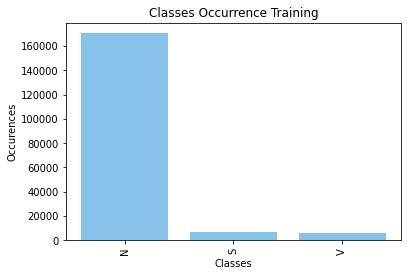

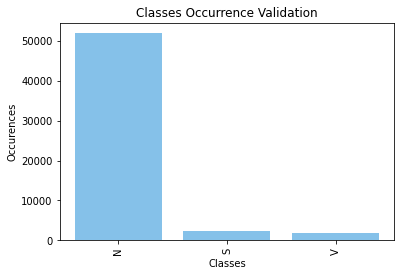

In [ ]:
#plot of labels'distribution in order to check the proportions, result of the stratified sampling.

plt.bar(x=np.unique(all_labels_train),height=np.unique(all_labels_train, return_counts= True)[1], facecolor ='#85c1e9')
plt.title("Classes Occurrence Training", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

plt.bar(x=np.unique(all_labels_val),height=np.unique(all_labels_val, return_counts= True)[1], facecolor ='#85c1e9')
plt.title("Classes Occurrence Validation", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

## 128Hz and 250Hz division

In [ ]:
#here we divided the data between 128Hz recordings and 250Hz recordings.
data_128_train = [j for j in training_data if j[0].shape[0] == 230400]
data_250_train = [j for j in training_data if j[0].shape[0] == 450000]
data_128_val = [j for j in validation_data if j[0].shape[0] == 230400]
data_250_val = [j for j in validation_data if j[0].shape[0] == 450000]
print(len(data_128_train), len(data_250_train), len(data_128_val), len(data_250_val)) 

## Extraction of Leads from signals 128 and 250

In [ ]:
#extraction of lead's signals, which before where in a different format, impossible to be handled singularly. 
data = [data_128_train, data_250_train, data_128_val, data_250_val]
rate = [128,250,128,250]
for k,j in enumerate(data):
  for i,patient in enumerate(j):
    lead1=[]
    lead2=[]
    for sample in patient[0]:
      lead1.append(np.squeeze(sample[0]))
      lead2.append(np.squeeze(sample[1]))
    data[k][i].append(lead1)
    data[k][i].append(lead2)  

# Recordings preprocessing


## Signal Visualization (with Filter and Clean)

In [ ]:
#visualization of the signals to which has been applied either filtering or ecg_clean, in order to decide which of the two to apply.

print("Recordings")
for j in range(len(recordings)):
  print("SIGNAL NUMBER", j)
  
  random_peak = random.choice(r_peaks_positions[j])
  while(random_peak<160):
    random_peak = random.choice(r_peaks_positions[j])
    
  if(j<65):
    freq=128
    win_min = 80
    win_max = 50
  else:
    freq=250
    win_min = 160
    win_max = 100

  t = np.arange(0, len(np.squeeze(recordings[j][:,0])), 1) #temporal vector
  figs, axs = plt.subplots(2, 3, sharex=True, figsize=(26,3))
  axs[0,0].plot(t, np.squeeze(recordings[j][:,0]), color='C1')
  axs[0,0].set_title(str("Train_250_Lead1_"+str(j)))
  axs[0,1].plot(t, nk.ecg_clean(np.squeeze(recordings[j][:,0]), sampling_rate=freq), color='C2')
  axs[0,1].set_title(str("Train_250_Lead1_Clean_"+str(j)))
  axs[0,2].plot(t, bandpass_filter(np.squeeze(recordings[j][:,0]), 1, 35, freq, 3), color='C3')
  axs[0,2].set_title(str("Train_250_Lead1_Filtered_"+str(j)))


  axs[1,0].plot(t, np.squeeze(recordings[j][:,1]), color='C1')
  axs[1,0].set_title(str("Train_250_Lead2_"+str(j)))
  axs[1,1].plot(t, nk.ecg_clean(np.squeeze(recordings[j][:,1]), sampling_rate=freq), color='C2')
  axs[1,1].set_title(str("Train_250_Lead2_Clean_"+str(j)))
  axs[1,2].plot(t, bandpass_filter(np.squeeze(recordings[j][:,1]), 1, 35, freq, 3), color='C3')
  axs[1,2].set_title(str("Train_250_Lead2_Filtered_"+str(j)))
  plt.show()


  t = np.arange(0, len(np.squeeze(recordings[j][:,0])), 1) #temporal vector
  figs, axs = plt.subplots(2, 3, sharex=True, figsize=(26,3))
  axs[0,0].plot(np.arange(0,win_min+win_max,1), np.squeeze(recordings[j][:,0][random_peak-win_min:random_peak+win_max]), color='C1')
  axs[0,0].set_title(str("Train_250_Lead1_RandomPeak "+str(j)))
  axs[0,1].plot(np.arange(0,win_min+win_max,1), nk.ecg_clean(np.squeeze(recordings[j][:,0][random_peak-win_min:random_peak+win_max]), sampling_rate=freq), color='C2')
  axs[0,1].set_title(str("Train_250_Lead1_Clean_RandomPeak "+str(j)))
  axs[0,2].plot(np.arange(0,win_min+win_max,1), bandpass_filter(np.squeeze(recordings[j][:,0][random_peak-win_min:random_peak+win_max]), 0.5, 40, freq, 3), color='C3')
  axs[0,2].set_title(str("Train_250_Lead1_Filtered_RandomPeak "+str(j)))
  #axs[1,2].set_xlim(random_peak-win_min,random_peak+win_max)
  
  axs[1,0].plot(np.arange(0,win_min+win_max,1), np.squeeze(recordings[j][:,1][random_peak-win_min:random_peak+win_max]), color='C1')
  axs[1,0].set_title(str("Train_250_Lead2_RandomPeak "+str(j)))
  axs[1,1].plot(np.arange(0,win_min+win_max,1), nk.ecg_clean(np.squeeze(recordings[j][:,1][random_peak-win_min:random_peak+win_max]), sampling_rate=freq), color='C2')
  axs[1,1].set_title(str("Train_250_Lead2_Clean_RandomPeak "+str(j)))
  axs[1,2].plot(np.arange(0,win_min+win_max,1), bandpass_filter(np.squeeze(recordings[j][:,1][random_peak-win_min:random_peak+win_max]), 0.5, 40, freq, 3), color='C3')
  axs[1,2].set_title(str("Train_250_Lead2_Filtered_RandomPeak "+str(j)))
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from collections import Counter
print(Counter(labels[97]))
print(Counter(labels[100]))
#data_250_train[19][1]

# We can remove 100 and 97

Counter({'N': 2504, 'V': 1})
Counter({'N': 1872, 'V': 1})


## Filtering

In [ ]:
#the filter has been applied in the band [0.5, 40]Hz
rate = [128,250,128,250]
for k,j in enumerate(data):
  for i,patient in enumerate(j):
    data[k][i][3]= bandpass_filter(data[k][i][3], 0.5, 40, rate[k], 3)
    data[k][i][4]= bandpass_filter(data[k][i][4], 0.5, 40, rate[k], 3)

## Normalization 

In [ ]:
#computation of the means and standard deviations of all the leads.
all_signals = []
all_signals_conc = []

for k in [0,1]:
  for i,patient in enumerate(data[k]):

    all_signals.append(patient[3])
    all_signals.append(patient[4])


#computation of the average of the means and the standard deviations calculated before. 
means = []
stds = []
for i in all_signals:
  means.append(np.mean(i))
  stds.append(np.std(i))

train_mean = np.mean(means)
train_std = np.mean(stds)
print(train_mean)
print(train_std)

1.3566639046590268e-06
0.2667258812997834


In [ ]:
for k,j in enumerate(data): #subtraction and division of all the leads with the values previously found. 
  for i,patient in enumerate(j):
    data[k][i][3] = (data[k][i][3]-train_mean)/train_std
    data[k][i][4] = (data[k][i][4]-train_mean)/train_std

## Heartbeat subdivision

### 1st method - Max distance extraction 

list of heartbeats (1 list per lead), all patients concatenated; take max dist between 2 R paeks for each sampling freq and cut around R peak of +- half the max, so heartbeats fed to the network contain R peak and same num of samples;


In [ ]:
#extract max dist between R peaks in train 128 and train 250
max_128=0
max_250=0
peak_prec=0
for i,patient in enumerate(data_128_train):
  peak_prec=0
  if (i != 35 and i != 1 and i != 20 and i != 11 and i != 41):
    for j in patient[1]:
        temp_max=j-peak_prec
        peak_prec=j
        if temp_max>max_128:
          pa=i
          max_128=temp_max
print(max_128)
print(pa)

peak_prec=0
for i,patient in enumerate(data_250_train):
  peak_prec=0
  if (i != 25 and i != 19 and i != 12 ):
    for j in patient[1]:
      temp_max=j-peak_prec
      peak_prec=j
      if temp_max>max_250:
        pa=i
        max_250=temp_max
print(max_250)
print(pa)
''' 

In [ ]:
#plus 1 because otherwise after upsampling or downsampling the windows didn't have the same dimensions, so in this way they match.
max_250=int(max_128/128*250)+1
max_250

In [ ]:
# Select window dimensions
sup_all=[max_128,max_250,max_128,max_250]
inf_all=[max_128,max_250,max_128,max_250]

list_hb_train_128_l1=[]
list_hb_train_250_l1=[]
list_hb_val_128_l1=[]
list_hb_val_250_l1=[]

list_hb_train_128_l2=[]
list_hb_train_250_l2=[]
list_hb_val_128_l2=[]
list_hb_val_250_l2=[]

count =0
for k,j in enumerate(data):
  for i,patient in enumerate(j):
    for peak_temp in patient[1]:
      '''if k == 1:
        count += 1
        if i == 12:
          print(count) #remove
          '''
      beginning=peak_temp-int(inf_all[k]) 
      ending=peak_temp+int(sup_all[k])
      
      if (beginning>0) and (ending<len(patient[3])):
        hb_temp_l1=patient[3][beginning:ending]
        hb_temp_l2=patient[4][beginning:ending]
      else: #1st and last hearbeats for each patient might not have enough samples before or after R peak
        if (beginning<0):
          hb_temp_l1=patient[3][0:ending]
          hb_temp_l2=patient[4][0:ending]
          pad1=(np.ones(abs(beginning)))*hb_temp_l1[0].tolist()
          hb_temp_l1=[*pad1, *hb_temp_l1]
          pad2=(np.ones(abs(beginning)))*hb_temp_l2[0].tolist()
          hb_temp_l2=[*pad2, *hb_temp_l2]
          '''
          hb_temp_l1=tfk.preprocessing.sequence.pad_sequences([hb_temp_l1], maxlen=abs(beginning), padding='pre', value=hb_temp_l1[0])
          hb_temp_l2=tfk.preprocessing.sequence.pad_sequences([hb_temp_l2], maxlen=abs(beginning), padding='pre', value=hb_temp_l2[0])
          hb_temp_l1=np.squeeze(hb_temp_l1)
          hb_temp_l2=np.squeeze(hb_temp_l2)
          '''
        elif (ending>len(patient[3])):
          hb_temp_l1=patient[3][beginning:-1]
          hb_temp_l2=patient[4][beginning:-1]
          pad1=(np.ones(ending-len(patient[3])+1)*hb_temp_l1[-1]).tolist()
          hb_temp_l1=[*hb_temp_l1 , *pad1]
          pad2=(np.ones(ending-len(patient[3])+1)*hb_temp_l2[-1]).tolist()
          hb_temp_l2=[*hb_temp_l2 ,*pad2]
          '''tfk.preprocessing.sequence.pad_sequences([hb_temp_l1], maxlen=(ending-len(patient[3])), padding='post', value=hb_temp_l1[-1])
          tfk.preprocessing.sequence.pad_sequences([hb_temp_l2], maxlen=(ending-len(patient[3])), padding='post', value=hb_temp_l2[-1])'''
        #print(f"lost 1st or last heartbeats of patient ", i) #here we just remove the beat, or else we could pad it
        #print(f"in data ", k)

      if (k==0):
          list_hb_train_128_l1.append(hb_temp_l1) #each pos is samples of hb (list of lists)
          list_hb_train_128_l2.append(hb_temp_l2)
      elif (k==1):
          list_hb_train_250_l1.append(hb_temp_l1)
          list_hb_train_250_l2.append(hb_temp_l2)
      elif (k==2):
          list_hb_val_128_l1.append(hb_temp_l1)
          list_hb_val_128_l2.append(hb_temp_l2)
      elif (k==3):
          list_hb_val_250_l1.append(hb_temp_l1)
          list_hb_val_250_l2.append(hb_temp_l2)

In [ ]:
len(list_hb_train_250_l1),len(list_hb_train_128_l1)

In [ ]:
len(list_hb_val_250_l1),len(list_hb_val_128_l1)
                         

### 2nd method - Empirical window extraction

#### Window selection
Best for 128 => -80 : 50

Best for 250 => -156 : 98

Empirical experiments with different windows. Here reported are just the ones chosen at the end. 

In [ ]:
np.unique(data_128_train[0][2], return_counts=True)

(array(['N', 'S', 'V'], dtype='<U1'), array([2811,   12,   28]))

In [ ]:
data_128_train[1][1][data_128_train[1][2]== 'S'][:]

array([   440,    636,    831,   1028,   1225,   1420,   1614,   1811,
         2008,   2203,   2398,   2594,   2790,   2985,   3179,   3374,
         3571,   3765,   3960,   4156,   4352,   4546,   4742,   4942,
         6121,   6317,   6714,   6911,   7106,   7303,   7501,   7696,
         7891,   8087,   8285,   8483,   8680,   8875,   9072,   9269,
         9466,   9661,   9859,  10056,  10254,  10450,  10649,  10844,
        11041,  11240,  11439,  11635,  11831,  12028,  12226,  12422,
        12618,  12815,  13012,  13208,  13407,  13604,  13802,  13999,
        14197,  14397,  14596,  14794,  14992,  15191,  15390,  15586,
        15784,  15985,  16184,  16382,  16580,  16780,  16978,  17175,
        17373,  17572,  17769,  17966,  18162,  18361,  18557,  18753,
        18949,  19147,  19347,  19546,  19741,  19940,  20137,  20335,
        20533,  20732,  20931,  21128,  21325,  21524,  21721,  21917,
        22114,  22312,  22509,  22705,  22902,  23100,  23297,  23495,
      

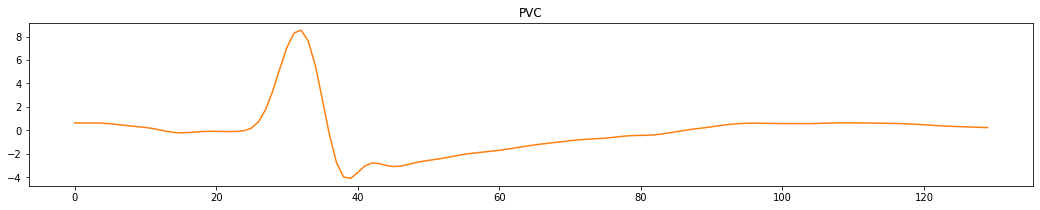

In [ ]:
# -80 : 50
t = np.arange(0, len(data_128_train[1][3][40640-80:40640+50]), 1) 
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(18,3))
axs.plot(t, data_250_train[1][3][40640-80:40640+50], color='C1')
axs.set_title("PVC")
plt.show()
#if you look closely it actually is 0 mean


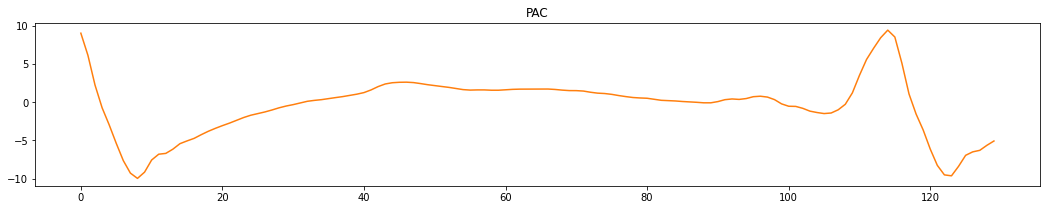

In [ ]:
# -80 : 50
t = np.arange(0, len(data_128_val[5][3][147886-80:147886+50]), 1) 
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(18,3))
axs.plot(t, data_128_val[5][3][147886-80:147886+50], color='C1')
axs.set_title("PAC")
plt.show()

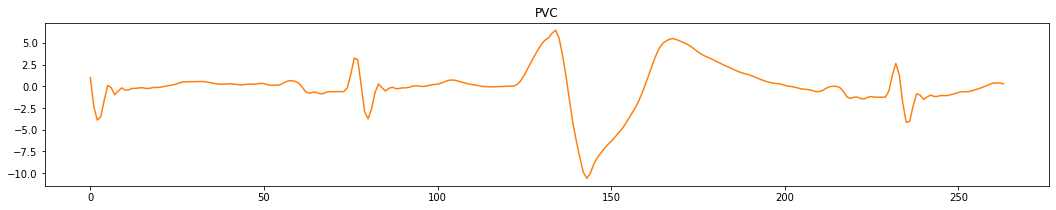

In [ ]:
# -132 : 132
t = np.arange(0, len(data_128_train[0][3][67737-132:67737+132]), 1) 
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(18,3))
axs.plot(t, data_128_train[0][3][67737-132:67737+132], color='C1')
axs.set_title("PVC")
plt.show()

#### Extraction bigger windows

In [ ]:
# Select window dimensions
sup_all=[132,258,132,258]
inf_all=[132,258,132,258]

list_hb_train_128_l1=[]
list_hb_train_250_l1=[]
list_hb_val_128_l1=[]
list_hb_val_250_l1=[]

list_hb_train_128_l2=[]
list_hb_train_250_l2=[]
list_hb_val_128_l2=[]
list_hb_val_250_l2=[]

count =0
for k,j in enumerate(data):
  for i,patient in enumerate(j):
    for peak_temp in patient[1]:
      '''if k == 1:
        count += 1
        if i == 12:
          print(count) #remove
          '''
      beginning=peak_temp-int(inf_all[k]) 
      ending=peak_temp+int(sup_all[k])
      
      if (beginning>0) and (ending<len(patient[3])):
        hb_temp_l1=patient[3][beginning:ending]
        hb_temp_l2=patient[4][beginning:ending]
      else: #1st and last hearbeats for each patient might not have enough samples before or after R peak
        if (beginning<0):
          hb_temp_l1=patient[3][0:ending]
          hb_temp_l2=patient[4][0:ending]
          pad1=(np.ones(abs(beginning)))*hb_temp_l1[0].tolist()
          hb_temp_l1=[*pad1, *hb_temp_l1]
          pad2=(np.ones(abs(beginning)))*hb_temp_l2[0].tolist()
          hb_temp_l2=[*pad2, *hb_temp_l2]
          '''
          hb_temp_l1=tfk.preprocessing.sequence.pad_sequences([hb_temp_l1], maxlen=abs(beginning), padding='pre', value=hb_temp_l1[0])
          hb_temp_l2=tfk.preprocessing.sequence.pad_sequences([hb_temp_l2], maxlen=abs(beginning), padding='pre', value=hb_temp_l2[0])
          hb_temp_l1=np.squeeze(hb_temp_l1)
          hb_temp_l2=np.squeeze(hb_temp_l2)
          '''
        elif (ending>len(patient[3])):
          hb_temp_l1=patient[3][beginning:-1]
          hb_temp_l2=patient[4][beginning:-1]
          pad1=(np.ones(ending-len(patient[3])+1)*hb_temp_l1[-1]).tolist()
          hb_temp_l1=[*hb_temp_l1 , *pad1]
          pad2=(np.ones(ending-len(patient[3])+1)*hb_temp_l2[-1]).tolist()
          hb_temp_l2=[*hb_temp_l2 ,*pad2]
          '''tfk.preprocessing.sequence.pad_sequences([hb_temp_l1], maxlen=(ending-len(patient[3])), padding='post', value=hb_temp_l1[-1])
          tfk.preprocessing.sequence.pad_sequences([hb_temp_l2], maxlen=(ending-len(patient[3])), padding='post', value=hb_temp_l2[-1])'''
        #print(f"lost 1st or last heartbeats of patient ", i) #here we just remove the beat, or else we could pad it
        #print(f"in data ", k)

      if (k==0):
          list_hb_train_128_l1.append(hb_temp_l1) #each pos is samples of hb (list of lists)
          list_hb_train_128_l2.append(hb_temp_l2)
      elif (k==1):
          list_hb_train_250_l1.append(hb_temp_l1)
          list_hb_train_250_l2.append(hb_temp_l2)
      elif (k==2):
          list_hb_val_128_l1.append(hb_temp_l1)
          list_hb_val_128_l2.append(hb_temp_l2)
      elif (k==3):
          list_hb_val_250_l1.append(hb_temp_l1)
          list_hb_val_250_l2.append(hb_temp_l2)

#### Extraction smaller windows

In [ ]:
# Select window dimensions
sup_all=[50,98,50,98]
inf_all=[80,156,80,156]

list_hb_train_128_l1=[]
list_hb_train_250_l1=[]
list_hb_val_128_l1=[]
list_hb_val_250_l1=[]

list_hb_train_128_l2=[]
list_hb_train_250_l2=[]
list_hb_val_128_l2=[]
list_hb_val_250_l2=[]

count =0
for k,j in enumerate(data):
  for i,patient in enumerate(j):
    for peak_temp in patient[1]:
      '''if k == 1:
        count += 1
        if i == 12:
          print(count) #remove
          '''
      beginning=peak_temp-int(inf_all[k]) 
      ending=peak_temp+int(sup_all[k])
      
      if (beginning>0) and (ending<len(patient[3])):
        hb_temp_l1=patient[3][beginning:ending]
        hb_temp_l2=patient[4][beginning:ending]
      else: #1st and last hearbeats for each patient might not have enough samples before or after R peak
        if (beginning<0):
          hb_temp_l1=patient[3][0:ending]
          hb_temp_l2=patient[4][0:ending]
          pad1=(np.ones(abs(beginning)))*hb_temp_l1[0].tolist()
          hb_temp_l1=[*pad1, *hb_temp_l1]
          pad2=(np.ones(abs(beginning)))*hb_temp_l2[0].tolist()
          hb_temp_l2=[*pad2, *hb_temp_l2]
          '''
          hb_temp_l1=tfk.preprocessing.sequence.pad_sequences([hb_temp_l1], maxlen=abs(beginning), padding='pre', value=hb_temp_l1[0])
          hb_temp_l2=tfk.preprocessing.sequence.pad_sequences([hb_temp_l2], maxlen=abs(beginning), padding='pre', value=hb_temp_l2[0])
          hb_temp_l1=np.squeeze(hb_temp_l1)
          hb_temp_l2=np.squeeze(hb_temp_l2)
          '''
        elif (ending>len(patient[3])):
          hb_temp_l1=patient[3][beginning:-1]
          hb_temp_l2=patient[4][beginning:-1]
          pad1=(np.ones(ending-len(patient[3])+1)*hb_temp_l1[-1]).tolist()
          hb_temp_l1=[*hb_temp_l1 , *pad1]
          pad2=(np.ones(ending-len(patient[3])+1)*hb_temp_l2[-1]).tolist()
          hb_temp_l2=[*hb_temp_l2 ,*pad2]
          '''tfk.preprocessing.sequence.pad_sequences([hb_temp_l1], maxlen=(ending-len(patient[3])), padding='post', value=hb_temp_l1[-1])
          tfk.preprocessing.sequence.pad_sequences([hb_temp_l2], maxlen=(ending-len(patient[3])), padding='post', value=hb_temp_l2[-1])'''
        #print(f"lost 1st or last heartbeats of patient ", i) #here we just remove the beat, or else we could pad it
        #print(f"in data ", k)

      if (k==0):
          list_hb_train_128_l1.append(hb_temp_l1) #each pos is samples of hb (list of lists)
          list_hb_train_128_l2.append(hb_temp_l2)
      elif (k==1):
          list_hb_train_250_l1.append(hb_temp_l1)
          list_hb_train_250_l2.append(hb_temp_l2)
      elif (k==2):
          list_hb_val_128_l1.append(hb_temp_l1)
          list_hb_val_128_l2.append(hb_temp_l2)
      elif (k==3):
          list_hb_val_250_l1.append(hb_temp_l1)
          list_hb_val_250_l2.append(hb_temp_l2)

### Plot a random S

In [ ]:
patient_number = 3
label_type = "S"

In [ ]:
data_128_train[patient_number][1][data_128_train[patient_number][2]==label_type][:]

array([115016, 130175, 130273, 130349, 130419, 130514, 130614, 130706,
       130781, 130870, 130959, 131039, 131118, 131205, 131279, 131349,
       131422, 131495, 131569, 131641], dtype=int32)

In [ ]:
np.where(data_128_train[patient_number][1] == 130175)

(array([1020]),)

In [ ]:
peak_position = random.choice(list(data_128_train[patient_number][1][data_128_train[patient_number][2]==label_type][:]))
print(peak_position)
# Find the index in the patient (label position in the patient)
label_pos = list(data_128_train[patient_number][1]).index(peak_position)

# Count the previous labels associated with the previous patients
position = 0
for j in range(patient_number):
  position = position + len(data_128_train[j][1])

# retrieve the final position in the array
position = position+label_pos
print(position)
# Plot
plotSignal([list_hb_train_128_l1[position]] , sampling_rate = 128)

## Resampling

### Upsampling

nk.signal_resemple -> to upscale the signals with sampling rate = 128 to sampling rate = 250

In [ ]:
lead1_128up250_train = []
lead2_128up250_train = []
lead1_128up250_val = []
lead2_128up250_val = []
all_origin = [list_hb_train_128_l1, list_hb_train_128_l2, list_hb_val_128_l1, list_hb_val_128_l2]
all = [lead1_128up250_train, lead2_128up250_train,lead1_128up250_val, lead2_128up250_val ]
for j,lead  in enumerate(all_origin):
  for k, heartbeat in enumerate(lead):
    all[j].append(nk.signal_resample(heartbeat, desired_length=None, sampling_rate=128, desired_sampling_rate=250, method="numpy"))
    

In [ ]:
len(lead1_128up250_train[-1]), len(list_hb_train_250_l1[4])

In [ ]:
len(list_hb_val_128_l1[0]),len(lead1_128up250_val[0])

### Downsampling

nk.signal_resemple -> to downscale the signals with sampling rate = 250 to sampling rate = 128

In [ ]:
lead1_250down128_train = []
lead2_250down128_train = []
lead1_250down128_val = []
lead2_250down128_val = []
all_originD = [list_hb_train_250_l1, list_hb_train_250_l2, list_hb_val_250_l1, list_hb_val_250_l2]
allD = [lead1_250down128_train, lead2_250down128_train,lead1_250down128_val, lead2_250down128_val ]
for j,lead  in enumerate(all_originD):
  for k, heartbeat in enumerate(lead):
    allD[j].append(nk.signal_resample(heartbeat, desired_length=None, sampling_rate=250, desired_sampling_rate=128, method="numpy"))

In [ ]:
len(lead1_250down128_train[2]), len(list_hb_train_128_l1[2])

In [ ]:
len(lead1_250down128_train[1]),len(list_hb_train_250_l1[1])

# Heartbeats datasets creation



### Training and validation labels

In [ ]:
y_train=[]
for i in range(len(data_128_train)):
    y_train=np.concatenate([y_train,data_128_train[i][2].copy()],axis=0)
len(y_train),len(y_train[0])

In [ ]:
y_temp=[]
for i in range(len(data_250_train)):
    y_temp=np.concatenate([y_temp,data_250_train[i][2].copy()],axis=0)
len(y_temp),len(y_temp[0])

In [ ]:
y_train=[*y_train,*y_temp]
len(y_train),len(y_train[0])

In [ ]:
y_val=[]
for i in range(len(data_128_val)):
    y_val=np.concatenate([y_val,data_128_val[i][2].copy()],axis=0)
len(y_val),len(y_val[0])

In [ ]:
y_temp=[]
for i in range(len(data_250_val)):
    y_temp=np.concatenate([y_temp,data_250_val[i][2].copy()],axis=0)
len(y_temp),len(y_temp[0])

In [ ]:
y_val=[*y_val,*y_temp]
len(y_val),len(y_val[0])

### Training dataset upsampled

In [ ]:
trainUP=[]
trainUP=[[*lead1_128up250_train.copy() , *list_hb_train_250_l1.copy()]]
trainUP.append([*lead2_128up250_train.copy() , *list_hb_train_250_l2.copy()])
#128 signals come before 250 ones

In [ ]:
len(trainUP),len(trainUP[0]),len(trainUP[1])

### Validation dataset upsampled

In [ ]:
valUP=[]
valUP=[[*lead1_128up250_val.copy() , *list_hb_val_250_l1.copy()]]
valUP.append([*lead2_128up250_val.copy() , *list_hb_val_250_l2.copy()])
#128 signals come before 250 ones

In [ ]:
len(valUP),len(valUP[0]),len(valUP[1])

### Training dataset downsampled

In [ ]:
trainDOWN=[]
trainDOWN=[[*list_hb_train_128_l1.copy() , *lead1_250down128_train.copy()]]
trainDOWN.append([*list_hb_train_128_l2.copy() , *lead2_250down128_train.copy()])
#128 signals come before 250 ones

In [ ]:
len(trainDOWN),len(trainDOWN[0]),len(trainDOWN[1])

### Validation dataset downsampled

In [ ]:
valDOWN=[]
valDOWN=[[*list_hb_val_128_l1.copy() , *lead1_250down128_val.copy()]]
valDOWN.append([*list_hb_val_128_l2.copy() , *lead2_250down128_val.copy()])
#128 signals come before 250 ones

In [ ]:
len(valDOWN),len(valDOWN[0]),len(valDOWN[1])

# Wide features extraction


## RR

In [ ]:
#extraction of R-R peaks distances. 
Rprec_train = []
Rprec_val = []
Rsucc_train = []
Rsucc_val = []
for k,j in enumerate(data):
  for i,patient in enumerate(j):
    for r,peaks in enumerate(patient[1]):
      if (r == 0):
        if (k == 0 or k == 1):
          Rprec_train.append(peaks)
          Rsucc_train.append(patient[1][r+1]-peaks)
        elif (k == 2 or k == 3):
          Rprec_val.append(peaks)
          Rsucc_val.append(patient[1][r+1]-peaks)
      elif (r != 0 and r != (len(patient[1])-1)):
        if (k == 0 or k == 1):
          Rprec_train.append(patient[1][r]-patient[1][r-1])
          Rsucc_train.append(patient[1][r+1]-peaks)
        elif (k == 2 or k == 3):
          Rprec_val.append(patient[1][r]-patient[1][r-1])
          Rsucc_val.append(patient[1][r+1]-peaks)
      elif(r== len(patient[1])-1):
        if (k == 0 or k == 1):
          Rprec_train.append(patient[1][r]-patient[1][r-1])
          Rsucc_train.append(abs(len(patient[3])-peaks))
        elif (k == 2 or k == 3):
          Rprec_val.append(patient[1][r]-patient[1][r-1])
          Rsucc_val.append(abs(len(patient[3]-peaks)))

In [ ]:
len(Rprec_train),len(Rsucc_train)

In [ ]:
wide = pd.DataFrame.from_dict({'Rprec':Rprec_train,'Rsucc': Rsucc_train}) #creaion of the dataset.

## Kurtosis, Skewness

In [ ]:
from scipy import stats

In [ ]:
#Kurtosis and skewness in order to compute respectively 3rd aand 4th order statistics. 
skew = []
kurtosis = []

for k,j in enumerate(trainDOWN[0]):
  skew.append(stats.skew(j))
  kurtosis.append(stats.kurtosis(j))

In [ ]:
wide['Skewness'] = skew
wide['Kurtosis'] = kurtosis

In [ ]:
len(skew), len(kurtosis)

In [ ]:
wide.head(100)

,Rprec,Rsucc,Skewness,Kurtosis
0,29,81,1.772953,10.285387
1,81,81,0.752103,3.828631
2,81,81,0.722191,3.645747
3,81,81,0.630878,3.588953
4,81,80,0.591956,3.472842
...,...,...,...,...
95,79,80,0.987859,3.520193
96,80,80,0.887051,3.584235
97,80,80,0.809868,3.446579
98,80,80,0.616075,2.973862


## Wavelets coefficients

In [ ]:
#extraction of the wavelets coefficients until the 5 level of decomposition.
cd5 = []
cd4 = []
for k,j in enumerate(trainDOWN[0]):
  coeffs = pywt.wavedec(j,'db6', level=5)
  cA5, cD5, cD4, cD3,cD2, cD1 = coeffs
  cd4.append(cD4)
  cd5.append(cD5)


In [ ]:
cD4 = pd.DataFrame(cd4, columns = ['cD4_'+str(i) for i in range(len(cd4[:][0]))])
cD5 = pd.DataFrame(cd5, columns = ['cD5_'+str(i) for i in range(len(cd5[:][0]))])

In [ ]:
cD4.head()

,cD4_0,cD4_1,cD4_2,cD4_3,cD4_4,cD4_5,cD4_6,cD4_7,cD4_8,cD4_9,cD4_10,cD4_11,cD4_12,cD4_13,cD4_14,cD4_15,cD4_16,cD4_17
0,3.028752e-07,-1.921366e-10,3.970467e-22,-1.970207e-08,0.000025,-0.000875,-0.000098,-0.221548,-4.433826,-7.783896,3.491471,-2.920849,1.337289,-0.536789,0.833841,-0.291816,5.021371,6.352075
1,-4.866426e-01,-4.753292e-02,-3.549397e+00,-3.605487e+00,-2.015026,1.240718,-1.674625,0.459582,-4.478736,-8.067625,3.517551,-3.182005,1.431862,-0.507044,0.829195,-0.043748,5.169692,6.196506
2,-4.378594e-01,-1.923813e-02,-3.116494e+00,-3.153679e+00,-1.776521,1.155786,-1.890362,0.561651,-4.398772,-7.949366,3.362259,-2.977785,1.359563,-0.485728,0.731587,0.020038,5.094710,6.058596
3,-3.388869e-01,2.199397e-02,-2.321495e+00,-2.357682e+00,-1.433208,0.924879,-1.678765,0.562610,-3.660768,-7.391428,2.630253,-2.672879,1.277007,-0.454508,0.653172,0.293286,5.042075,4.911389
4,-1.966803e-02,1.074231e-01,5.901477e-02,1.090526e-01,-0.333387,0.182692,-1.354866,0.651708,-3.785285,-7.292515,2.838969,-2.516564,1.128440,-0.401650,0.716945,-0.173190,5.126374,4.997077


## Features DataFrame creation

In [ ]:
features = pd.concat([wide, cD4, cD5], axis = 1) #creation of the entire dataset with the features so far found. 

In [ ]:
features['Target'] = y_train #adding the target to the dataset. 

In [ ]:
features.head()

,Rprec,Rsucc,Skewness,Kurtosis,cD4_0,cD4_1,cD4_2,cD4_3,cD4_4,cD4_5,cD4_6,cD4_7,cD4_8,cD4_9,cD4_10,cD4_11,cD4_12,cD4_13,cD4_14,cD4_15,cD4_16,cD4_17,cD5_0,cD5_1,cD5_2,cD5_3,cD5_4,cD5_5,cD5_6,cD5_7,cD5_8,cD5_9,cD5_10,cD5_11,cD5_12,cD5_13,Target
0,29,81,1.772953,10.285387,3.028752e-07,-1.921366e-10,3.970467e-22,-1.970207e-08,0.000025,-0.000875,-0.000098,-0.221548,-4.433826,-7.783896,3.491471,-2.920849,1.337289,-0.536789,0.833841,-0.291816,5.021371,6.352075,-0.000056,-0.000015,0.000008,0.000302,-0.031381,-0.327463,0.752979,-0.091834,-2.157665,1.221495,-0.199133,2.277699,-2.469206,1.260049,N
1,81,81,0.752103,3.828631,-4.866426e-01,-4.753292e-02,-3.549397e+00,-3.605487e+00,-2.015026,1.240718,-1.674625,0.459582,-4.478736,-8.067625,3.517551,-3.182005,1.431862,-0.507044,0.829195,-0.043748,5.169692,6.196506,-0.252457,0.462951,0.578604,0.184627,-1.518487,-0.450390,1.846495,-0.273356,-2.937572,1.462473,0.139229,2.563471,-2.851789,-0.137914,N
2,81,81,0.722191,3.645747,-4.378594e-01,-1.923813e-02,-3.116494e+00,-3.153679e+00,-1.776521,1.155786,-1.890362,0.561651,-4.398772,-7.949366,3.362259,-2.977785,1.359563,-0.485728,0.731587,0.020038,5.094710,6.058596,-0.234214,0.430052,0.520312,0.167402,-1.601519,-0.266862,1.968841,-0.558591,-2.693037,1.382884,0.072853,2.607128,-2.649837,-0.695390,N
3,81,81,0.630878,3.588953,-3.388869e-01,2.199397e-02,-2.321495e+00,-2.357682e+00,-1.433208,0.924879,-1.678765,0.562610,-3.660768,-7.391428,2.630253,-2.672879,1.277007,-0.454508,0.653172,0.293286,5.042075,4.911389,-0.187925,0.352607,0.400926,0.121736,-1.516521,-0.168063,2.070834,0.074261,-3.004402,1.424405,0.252332,2.134432,-2.932417,-0.641779,N
4,81,80,0.591956,3.472842,-1.966803e-02,1.074231e-01,5.901477e-02,1.090526e-01,-0.333387,0.182692,-1.354866,0.651708,-3.785285,-7.292515,2.838969,-2.516564,1.128440,-0.401650,0.716945,-0.173190,5.126374,4.997077,-0.093983,0.159193,-0.035655,-0.095132,-1.582525,-0.711018,2.006494,0.521927,-2.795932,1.433180,0.009517,1.632353,-2.610874,-0.452018,N


In [ ]:
features.shape

## Validation features set

Same thing 

In [ ]:
wide_val = pd.DataFrame.from_dict({'Rprec':Rprec_val,'Rsucc': Rsucc_val})

In [ ]:
skew_val = []
kurtosis_val = []

for k,j in enumerate(valDOWN[0]):
  skew_val.append(stats.skew(j))
  kurtosis_val.append(stats.kurtosis(j))

In [ ]:
len(skew_val), len(kurtosis_val)

In [ ]:
wide_val['Skewness'] = skew_val
wide_val['Kurtosis'] = kurtosis_val

In [ ]:
cd5_val = []
cd4_val = []
for k,j in enumerate(valDOWN[0]):
  coeffs = pywt.wavedec(j,'db6', level=5)
  cA5, cD5, cD4, cD3,cD2, cD1 = coeffs
  cd4_val.append(cD4)
  cd5_val.append(cD5)

In [ ]:
cD4_val = pd.DataFrame(cd4_val, columns = ['cD4_'+str(i) for i in range(len(cd4_val[:][0]))])
cD5_val = pd.DataFrame(cd5_val, columns = ['cD5_'+str(i) for i in range(len(cd5_val[:][0]))])

In [ ]:
features_val = pd.concat([wide_val, cD4_val, cD5_val], axis = 1)

In [ ]:
features_val['Target'] = y_val

In [ ]:
features_val.head()

,Rprec,Rsucc,Skewness,Kurtosis,cD4_0,cD4_1,cD4_2,cD4_3,cD4_4,cD4_5,cD4_6,cD4_7,cD4_8,cD4_9,cD4_10,cD4_11,cD4_12,cD4_13,cD4_14,cD4_15,cD4_16,cD4_17,cD5_0,cD5_1,cD5_2,cD5_3,cD5_4,cD5_5,cD5_6,cD5_7,cD5_8,cD5_9,cD5_10,cD5_11,cD5_12,cD5_13,Target
0,71,82,-0.253314,3.625900,-0.025491,0.047544,-0.018011,-0.042758,-0.440253,-1.038373,1.524368,0.224681,5.247471,11.275517,-5.515744,3.059450,-1.464545,0.184935,0.596617,-0.190779,-6.267009,-8.263016,-0.064431,0.113362,0.000440,0.055185,0.063281,-3.325884,-2.059501,3.674834,3.938165,-1.712187,-0.468133,-7.542866,5.597602,1.694888,N
1,82,79,-0.166621,1.456797,0.739263,0.187836,5.626185,5.752030,3.175348,-1.000219,1.409432,0.214831,4.676823,11.894832,-4.775993,3.257001,-1.617716,0.363676,0.126552,-0.379382,-7.558279,-7.064486,0.364059,-0.651491,-0.886473,-0.337042,1.307379,-2.955772,-3.114222,1.817546,4.403180,-1.858646,-0.413210,-6.158214,6.545044,2.184975,N
2,79,48,-0.762037,1.344939,2.368539,0.849851,17.773871,18.460508,8.083852,-4.962135,3.213544,-0.304815,5.032484,11.062730,-4.917643,7.022951,-1.617977,1.239544,-5.692758,1.188951,-6.740490,-7.756385,0.641883,-1.299711,-3.304099,-1.704634,-0.153262,-6.636896,-0.761125,0.855736,-6.567265,-0.960332,9.933769,-5.885377,6.100379,2.785163,N
3,48,87,-0.791569,1.939386,0.192284,0.014261,1.174560,1.273042,1.163070,4.593971,11.047766,-4.740590,8.558202,9.500589,-5.157950,3.410358,-1.605470,0.348073,0.031401,0.353450,-6.774079,-7.751651,0.023360,-0.083561,-0.306241,-0.275611,0.795614,2.388740,-11.182566,5.582044,2.260284,-1.132912,-0.492668,-6.132388,10.681513,-1.035220,S
4,87,52,-0.290303,2.005361,-0.274069,-0.119533,-2.041383,-2.147320,-0.228932,0.146811,0.003726,0.812640,4.979634,11.416269,-4.226637,3.277800,-3.500277,2.385320,-0.054326,-1.002938,-6.918396,-7.576693,0.031844,-0.001101,0.470212,0.416198,2.222110,1.508353,-4.891207,3.541213,0.638053,-1.675251,3.015203,-7.109621,6.553723,-0.351948,N


In [ ]:
features_val.shape

## Wide feature data exploration

### Data visualization and summary statistics

In [ ]:
train_labels = features.Target
train_features = features.drop(columns='Target')
val_labels = features_val.Target
val_features = features_val.drop(columns='Target')

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:185: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



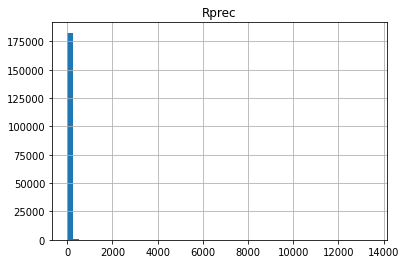

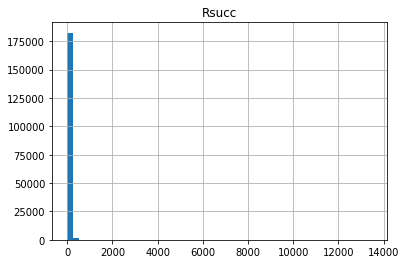

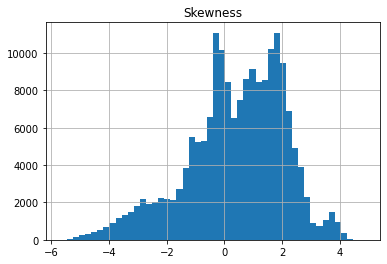

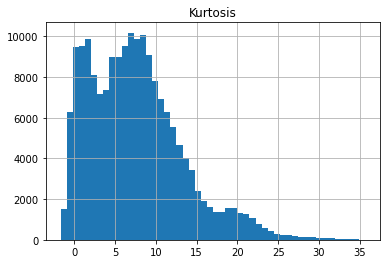

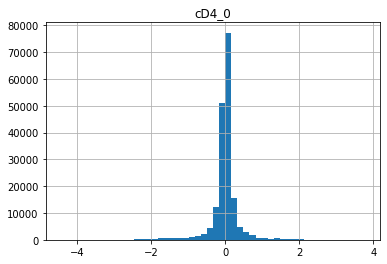

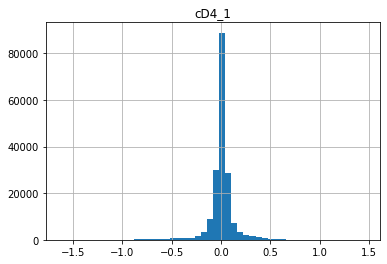

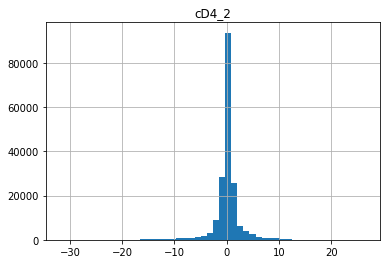

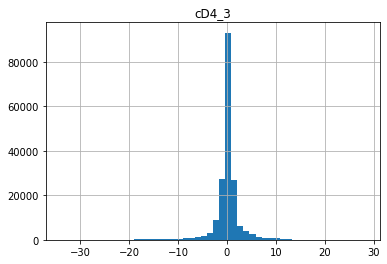

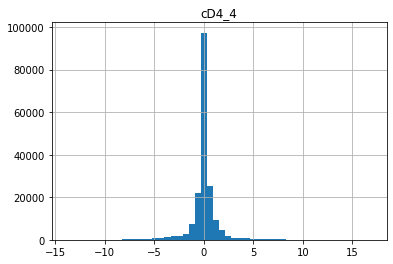

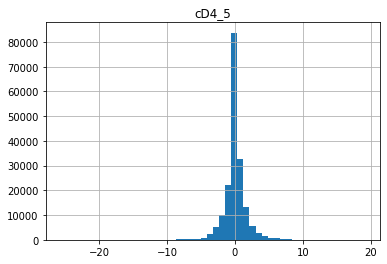

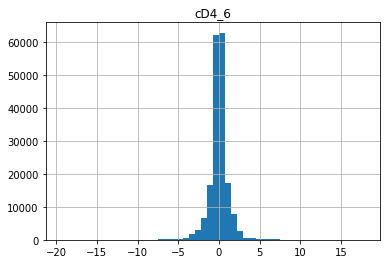

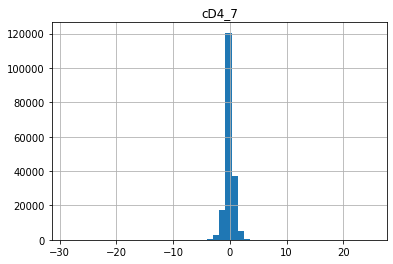

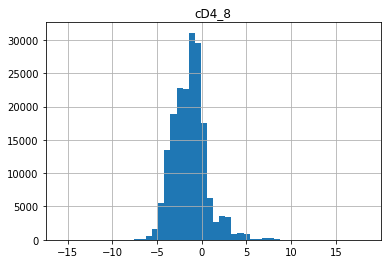

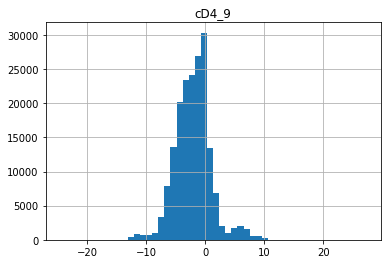

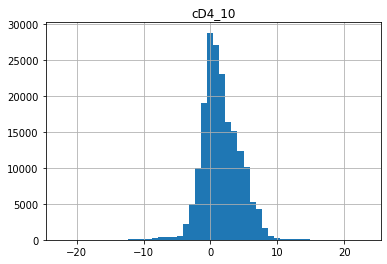

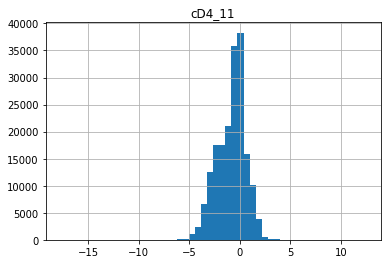

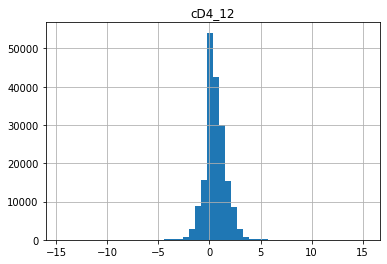

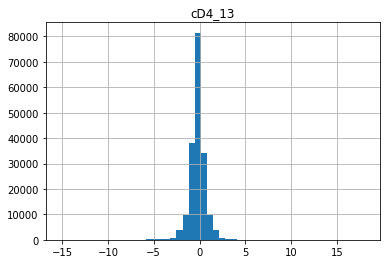

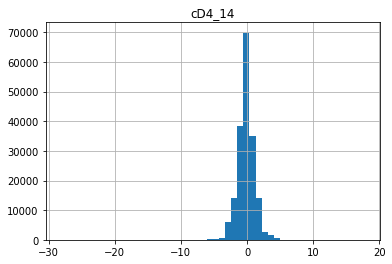

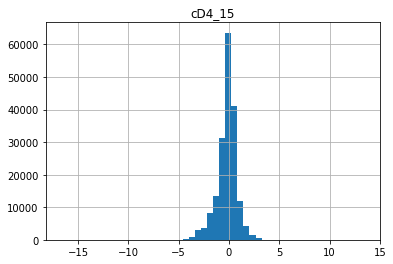

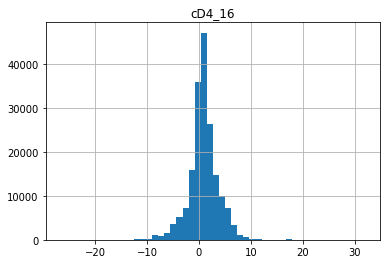

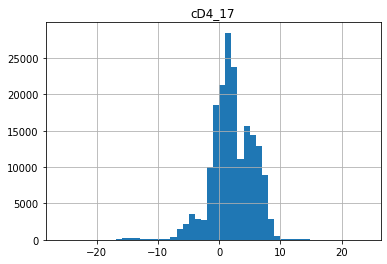

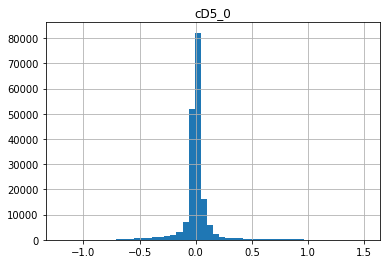

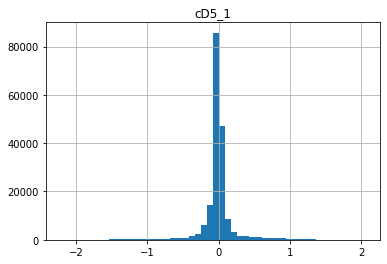

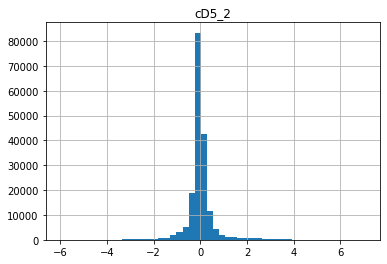

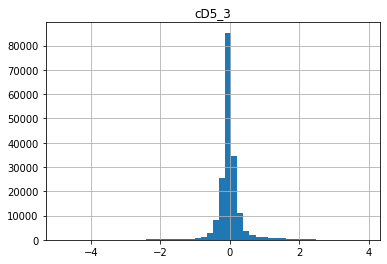

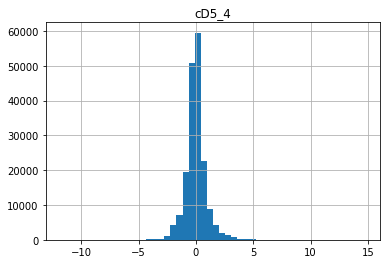

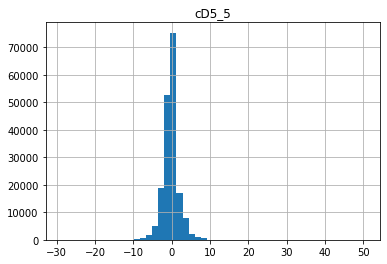

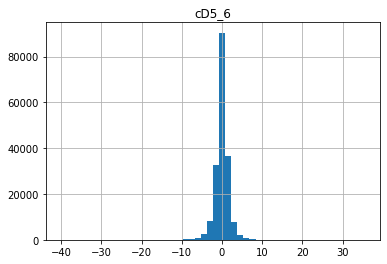

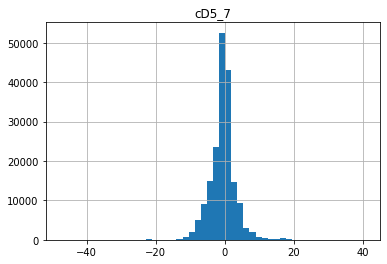

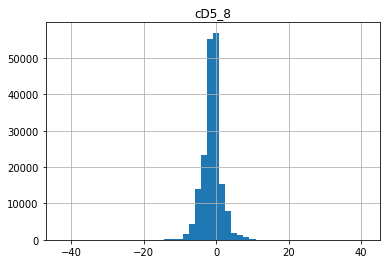

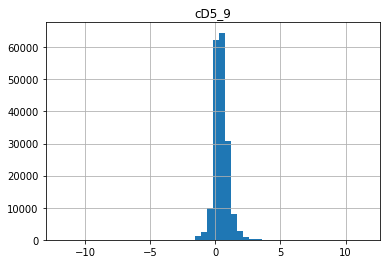

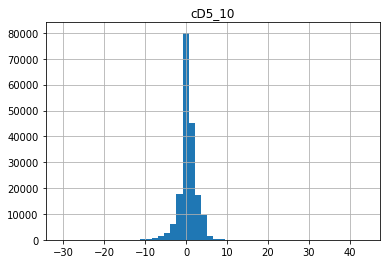

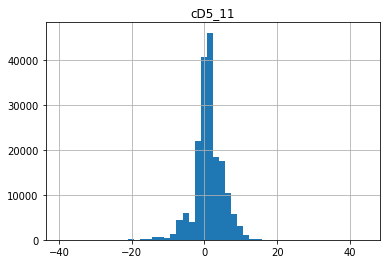

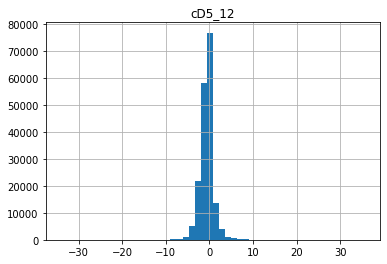

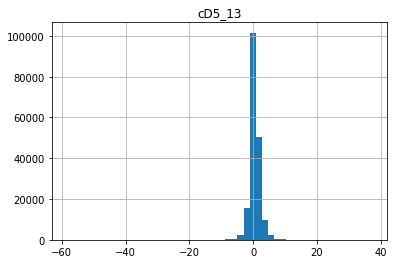

In [ ]:
for col in train_features.columns: 
      train_features.hist(column = col, bins = 50)

In [ ]:
features.describe()

,Rprec,Rsucc,Skewness,Kurtosis,cD4_0,cD4_1,cD4_2,cD4_3,cD4_4,cD4_5,cD4_6,cD4_7,cD4_8,cD4_9,cD4_10,cD4_11,cD4_12,cD4_13,cD4_14,cD4_15,cD4_16,cD4_17,cD5_0,cD5_1,cD5_2,cD5_3,cD5_4,cD5_5,cD5_6,cD5_7,cD5_8,cD5_9,cD5_10,cD5_11,cD5_12,cD5_13
count,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000,183728.000000
mean,130.174617,130.155017,0.383079,7.510854,0.010207,0.003199,0.072153,0.078890,0.062544,0.060991,-0.007117,-0.088457,-1.329936,-2.007449,1.551217,-0.846816,0.577060,-0.216907,-0.144591,-0.179937,0.853367,2.132511,0.002846,-0.006460,-0.014298,-0.009470,-0.023869,-0.171913,0.074343,-0.504581,-1.236187,0.430033,0.486894,1.192450,-0.639415,0.468299
std,68.029682,67.844173,1.694681,5.765411,0.391746,0.141789,2.644939,2.804602,1.456942,1.671416,1.185040,0.804933,1.918472,3.112912,2.797526,1.420471,1.122201,0.949945,1.251851,1.009170,2.871203,3.418282,0.143376,0.237521,0.621864,0.418719,0.935303,2.230530,1.883717,3.984915,2.739672,0.581400,2.136871,4.187885,1.681898,2.170815
min,1.000000,0.000000,-5.675820,-1.678845,-4.430239,-1.622938,-31.746062,-33.978293,-13.817243,-25.696164,-19.443620,-28.669588,-15.758695,-24.461713,-22.348054,-17.720970,-14.536394,-15.141605,-28.150323,-16.717257,-26.557910,-25.818792,-1.201489,-2.213548,-5.987229,-4.864078,-11.778599,-28.897804,-40.060517,-47.481593,-42.871165,-11.857162,-30.555612,-39.471609,-34.102623,-58.330512
25%,92.000000,92.000000,-0.555787,2.927350,-0.054230,-0.022875,-0.357671,-0.391256,-0.212573,-0.473980,-0.386982,-0.428394,-2.650910,-3.953357,-0.320287,-1.854442,-0.052810,-0.619366,-0.749252,-0.593666,-0.400879,0.123046,-0.021166,-0.034994,-0.175181,-0.119931,-0.460398,-1.098098,-0.700009,-2.162185,-2.462963,0.090306,-0.318369,-0.654479,-1.442962,-0.189283
50%,116.000000,116.000000,0.578762,6.905424,0.022998,0.008998,0.182997,0.195353,0.050456,0.000289,0.010295,-0.094967,-1.337566,-1.911883,1.245615,-0.618477,0.453924,-0.152682,-0.181219,-0.051354,0.729067,1.950320,-0.002283,-0.001626,-0.037321,-0.019214,-0.041565,-0.151133,0.133989,-0.338044,-1.061369,0.363607,0.358096,1.062394,-0.492848,0.414005
75%,162.000000,162.000000,1.676060,10.688525,0.106106,0.042571,0.774721,0.828625,0.330940,0.606457,0.387232,0.249696,-0.296857,-0.256343,3.356747,0.150139,1.187578,0.170477,0.533282,0.363296,2.244977,4.639164,0.020013,0.027369,0.092592,0.074871,0.346073,0.548150,0.838505,1.108308,-0.078426,0.733735,1.399432,3.153629,0.053925,1.144074
max,13473.000000,13473.000000,4.880287,35.665649,3.776085,1.461664,26.471856,28.264064,16.931230,19.199681,17.962800,24.951567,18.295979,27.148416,23.158568,12.436250,15.236845,18.078495,17.851546,13.542243,31.957777,23.861200,1.508783,2.058090,7.066462,3.891737,14.751613,50.471112,35.578989,40.652937,41.069844,11.504275,43.716039,44.194214,35.731912,37.038918


### Missing data

In [ ]:
percent_missing = features.isnull().sum() * 100 / len(features)
missing_value_df = pd.DataFrame({'column_name': features.columns,
                                 'percent_missing': percent_missing})
display(missing_value_df)


,column_name,percent_missing
Rprec,Rprec,0.0
Rsucc,Rsucc,0.0
Skewness,Skewness,0.0
Kurtosis,Kurtosis,0.0
cD4_0,cD4_0,0.0
cD4_1,cD4_1,0.0
cD4_2,cD4_2,0.0
cD4_3,cD4_3,0.0
cD4_4,cD4_4,0.0
cD4_5,cD4_5,0.0


In [ ]:
wide.describe()

,Rprec,Rsucc,Skewness,Kurtosis
count,183728.000000,183728.000000,183728.000000,183728.000000
mean,130.174617,130.155017,0.383079,7.510854
std,68.029682,67.844173,1.694681,5.765411
min,1.000000,0.000000,-5.675820,-1.678845
25%,92.000000,92.000000,-0.555787,2.927350
50%,116.000000,116.000000,0.578762,6.905424
75%,162.000000,162.000000,1.676060,10.688525
max,13473.000000,13473.000000,4.880287,35.665649


### Outliers removal

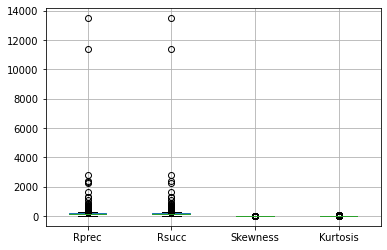

In [ ]:
wide.boxplot()

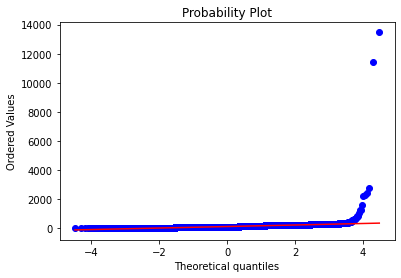

In [ ]:
import pylab   
stats.probplot(wide['Rprec'], dist="norm", plot=pylab)
pylab.show()

In [ ]:
r_succ = features['Rsucc'][features['Rsucc']>384].index.tolist()
r_prec = features['Rprec'][features['Rprec']>384].index.tolist()

In [ ]:
np.unique(features['Target'][r_prec], return_counts = True)

(array(['N'], dtype=object), array([37]))

In [ ]:
index_train = [*r_succ, *r_prec]

In [ ]:
len(index_train)

73

In [ ]:
filtered_up = features[(features['Rprec'] <384) & (features['Rsucc'] <384)]

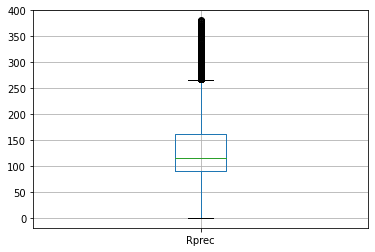

In [ ]:
filtered_up[['Rprec']].boxplot()

In [ ]:
r_succ_inf = filtered_up['Rsucc'][filtered_up['Rsucc']<30].index.tolist()
r_prec_inf = filtered_up['Rprec'][filtered_up['Rprec']<30].index.tolist()

In [ ]:
filtered_down = filtered_up[(filtered_up['Rprec'] >30) & (filtered_up['Rsucc'] >30)]

In [ ]:
filtered_down.describe()

,Rprec,Rsucc,Skewness,Kurtosis,cD4_0,cD4_1,cD4_2,cD4_3,cD4_4,cD4_5,cD4_6,cD4_7,cD4_8,cD4_9,cD4_10,cD4_11,cD4_12,cD4_13,cD4_14,cD4_15,cD4_16,cD4_17,cD5_0,cD5_1,cD5_2,cD5_3,cD5_4,cD5_5,cD5_6,cD5_7,cD5_8,cD5_9,cD5_10,cD5_11,cD5_12,cD5_13
count,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000,183501.000000
mean,129.965243,129.964518,0.383142,7.510213,0.010204,0.003210,0.072186,0.078936,0.062758,0.061280,-0.006974,-0.087878,-1.330681,-2.008525,1.553009,-0.846717,0.577129,-0.216841,-0.145204,-0.181015,0.853903,2.133540,0.002850,-0.006461,-0.014283,-0.009432,-0.023776,-0.171690,0.074730,-0.504718,-1.237182,0.430288,0.487392,1.193130,-0.640368,0.468457
std,52.804979,52.806673,1.694238,5.764344,0.391910,0.141851,2.645990,2.805713,1.457471,1.671497,1.185134,0.804598,1.918947,3.113942,2.798037,1.420532,1.122539,0.950224,1.251692,1.008457,2.872390,3.419485,0.143449,0.237634,0.622131,0.418908,0.935564,2.231052,1.883079,3.986208,2.740478,0.581528,2.137577,4.189344,1.680621,2.171539
min,31.000000,31.000000,-5.675820,-1.678845,-4.430239,-1.622938,-31.746062,-33.978293,-13.817243,-25.696164,-19.443620,-28.669588,-15.758695,-24.461713,-22.348054,-17.720970,-14.536394,-15.141605,-28.150323,-16.717257,-26.557910,-25.818792,-1.201489,-2.213548,-5.987229,-4.864078,-11.778599,-28.897804,-40.060517,-47.481593,-42.871165,-11.857162,-30.555612,-39.471609,-34.102623,-58.330512
25%,92.000000,92.000000,-0.555907,2.924984,-0.054313,-0.022853,-0.358004,-0.391323,-0.212461,-0.473820,-0.386923,-0.427964,-2.651812,-3.954991,-0.319166,-1.854058,-0.052793,-0.619401,-0.749637,-0.594348,-0.401288,0.123589,-0.021169,-0.034992,-0.175318,-0.119984,-0.460830,-1.099221,-0.699974,-2.164334,-2.464655,0.090432,-0.317961,-0.655033,-1.443882,-0.189395
50%,116.000000,116.000000,0.577847,6.907004,0.023050,0.009026,0.183268,0.195901,0.050635,0.000438,0.010444,-0.094759,-1.338559,-1.913751,1.247928,-0.618414,0.453929,-0.152642,-0.182133,-0.052083,0.729689,1.952472,-0.002288,-0.001628,-0.037411,-0.019199,-0.041598,-0.151279,0.134493,-0.338375,-1.062481,0.363780,0.358980,1.064272,-0.493705,0.414486
75%,162.000000,162.000000,1.675896,10.689657,0.106224,0.042607,0.775449,0.829572,0.331237,0.607336,0.387577,0.250135,-0.297631,-0.256796,3.360168,0.149921,1.187957,0.170630,0.532296,0.362713,2.246689,4.641976,0.020018,0.027372,0.092689,0.075015,0.346718,0.548999,0.839425,1.110572,-0.080088,0.734147,1.400386,3.157220,0.053091,1.144666
max,381.000000,381.000000,4.880287,35.665649,3.776085,1.461664,26.471856,28.264064,16.931230,19.199681,17.962800,24.951567,18.295979,27.148416,23.158568,12.436250,15.236845,18.078495,17.851546,13.542243,31.957777,23.861200,1.508783,2.058090,7.066462,3.891737,14.751613,50.471112,35.578989,40.652937,41.069844,11.504275,43.716039,44.194214,35.731912,37.038918


In [ ]:
np.unique(filtered_up['Target'][r_prec_inf], return_counts = True)

(array(['N', 'S'], dtype=object), array([39,  2]))

In [ ]:
r_succ_val = features_val['Rsucc'][features_val['Rsucc']>384].index.tolist()
r_prec_val = features_val['Rprec'][features_val['Rprec']>384].index.tolist()

In [ ]:
np.unique(features_val['Target'][r_succ_val], return_counts = True)

(array(['N', 'S', 'V'], dtype=object), array([26,  1,  2]))

In [ ]:
index_val = [*r_succ_val, *r_prec_val]

In [ ]:
filtered_val_up = features_val[(features_val['Rprec'] <384) & (features_val['Rsucc'] <384)]

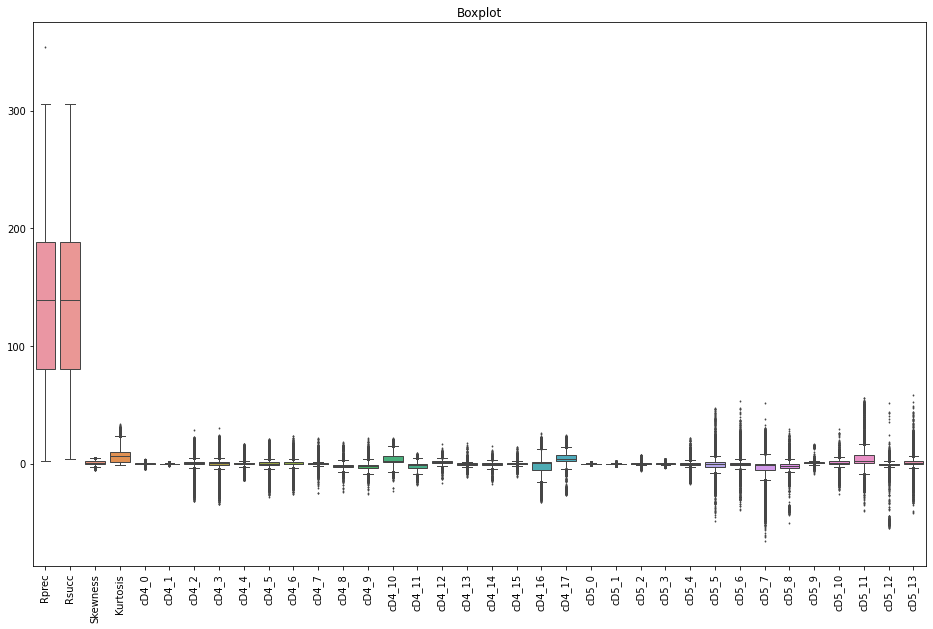

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Boxplot")
ax = sns.boxplot(data = filtered_val_up, linewidth=1,fliersize=1)
ax.set_xticklabels(filtered_val_up.columns, rotation=90)
plt.show()

In [ ]:
r_succ_inf_val = filtered_val_up['Rsucc'][filtered_val_up['Rsucc']<30].index.tolist()
r_prec_inf_val = filtered_val_up['Rprec'][filtered_val_up['Rprec']<30].index.tolist()

In [ ]:
np.unique(filtered_val_up['Target'][r_succ_inf_val], return_counts = True)

(array(['N', 'V'], dtype=object), array([1, 1]))

In [ ]:
filtered_val_down = filtered_val_up[(filtered_val_up['Rprec'] >30) & (filtered_val_up['Rsucc'] >30)]

In [ ]:
filtered_val_down

,Rprec,Rsucc,Skewness,Kurtosis,cD4_0,cD4_1,cD4_2,cD4_3,cD4_4,cD4_5,cD4_6,cD4_7,cD4_8,cD4_9,cD4_10,cD4_11,cD4_12,cD4_13,cD4_14,cD4_15,cD4_16,cD4_17,cD5_0,cD5_1,cD5_2,cD5_3,cD5_4,cD5_5,cD5_6,cD5_7,cD5_8,cD5_9,cD5_10,cD5_11,cD5_12,cD5_13,Target
0,71,82,-0.253314,3.625900,-0.025491,0.047544,-0.018011,-0.042758,-0.440253,-1.038373,1.524368,0.224681,5.247471,11.275517,-5.515744,3.059450,-1.464545,0.184935,0.596617,-0.190779,-6.267009,-8.263016,-0.064431,0.113362,0.000440,0.055185,0.063281,-3.325884,-2.059501,3.674834,3.938165,-1.712187,-0.468133,-7.542866,5.597602,1.694888,N
1,82,79,-0.166621,1.456797,0.739263,0.187836,5.626185,5.752030,3.175348,-1.000219,1.409432,0.214831,4.676823,11.894832,-4.775993,3.257001,-1.617716,0.363676,0.126552,-0.379382,-7.558279,-7.064486,0.364059,-0.651491,-0.886473,-0.337042,1.307379,-2.955772,-3.114222,1.817546,4.403180,-1.858646,-0.413210,-6.158214,6.545044,2.184975,N
2,79,48,-0.762037,1.344939,2.368539,0.849851,17.773871,18.460508,8.083852,-4.962135,3.213544,-0.304815,5.032484,11.062730,-4.917643,7.022951,-1.617977,1.239544,-5.692758,1.188951,-6.740490,-7.756385,0.641883,-1.299711,-3.304099,-1.704634,-0.153262,-6.636896,-0.761125,0.855736,-6.567265,-0.960332,9.933769,-5.885377,6.100379,2.785163,N
3,48,87,-0.791569,1.939386,0.192284,0.014261,1.174560,1.273042,1.163070,4.593971,11.047766,-4.740590,8.558202,9.500589,-5.157950,3.410358,-1.605470,0.348073,0.031401,0.353450,-6.774079,-7.751651,0.023360,-0.083561,-0.306241,-0.275611,0.795614,2.388740,-11.182566,5.582044,2.260284,-1.132912,-0.492668,-6.132388,10.681513,-1.035220,S
4,87,52,-0.290303,2.005361,-0.274069,-0.119533,-2.041383,-2.147320,-0.228932,0.146811,0.003726,0.812640,4.979634,11.416269,-4.226637,3.277800,-3.500277,2.385320,-0.054326,-1.002938,-6.918396,-7.576693,0.031844,-0.001101,0.470212,0.416198,2.222110,1.508353,-4.891207,3.541213,0.638053,-1.675251,3.015203,-7.109621,6.553723,-0.351948,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55983,234,228,1.455540,6.083757,0.046611,0.021671,0.316053,0.349935,-0.141304,-0.263078,0.068816,-0.293774,-2.226404,-1.896536,1.573605,-2.655038,2.432177,-1.547125,0.499249,1.008675,-0.080269,3.427577,-0.044175,0.054792,-0.113162,-0.108945,-0.678166,-0.677544,-0.256563,-0.535979,-1.900883,0.646776,0.913782,1.165200,0.072710,0.350856,N
55984,228,218,1.409794,5.673794,-0.240841,-0.071476,-1.780874,-1.863212,-0.979397,0.794887,-0.428856,-0.137826,-2.025033,-1.701551,1.290071,-2.498954,2.674260,-1.879838,0.561737,1.032921,-0.061120,3.051241,-0.069064,0.141866,0.332255,0.123514,-0.496842,0.252825,-0.589147,-0.217280,-1.174818,0.560870,0.271934,0.902570,0.056715,0.029340,N
55985,218,216,1.550738,6.334694,-0.437792,-0.135270,-2.954641,-3.234838,-1.109297,2.164931,-1.029649,0.229196,-1.956959,-1.415447,1.377765,-2.265236,2.285611,-1.480853,0.282726,0.982082,-0.389336,2.975600,0.075645,-0.017666,0.785434,0.444509,0.313750,2.357134,-1.722872,-0.254743,-1.720857,0.509211,0.928673,1.160356,0.180862,-0.572243,N
55986,216,214,1.532408,6.100846,-0.243187,-0.107773,-1.711263,-1.926984,-0.391973,2.049728,-1.120197,0.110867,-2.157972,-1.764620,1.051644,-2.564632,2.459849,-1.679473,0.704571,1.178818,0.068740,3.095311,0.122427,-0.125476,0.493797,0.261211,0.443309,2.566691,-1.710650,0.075919,-1.211321,0.488441,0.453224,0.728970,0.233336,-0.699138,N


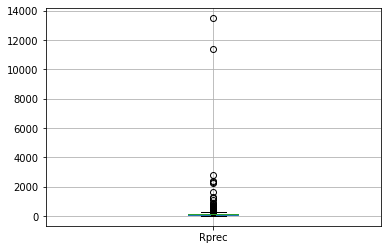

In [ ]:
wide[['Rprec']].boxplot()

## Save The Wide Features as csv

In [ ]:
#filtered_down.to_csv('/content/drive/MyDrive/A.I/FinalProject/Dataset/NewDataset_128/features_filtered_new.csv')
#filtered_val_down.to_csv('/content/drive/MyDrive/A.I/FinalProject/Dataset/NEW FILTERED V2/val_filtered_new.csv')

## Feature Transformation (Done in the notebook with models)

In [ ]:
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(train_features)
train_features_standardized = transformer.transform(train_features)
train_features_standardized = pd.DataFrame(data=train_features_standardized, columns=feature_list)

val_features_standardized = transformer.transform(val_features)
val_features_standardized = pd.DataFrame(data=val_features_standardized, columns=feature_list)

### Feature Selection

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

vt = VarianceThreshold(threshold=(0.01)) # eliminate constant features 
train_features_var = vt.fit_transform(train_features)
mask = vt.get_support()
print(mask)

train_features = train_features.loc[:, mask]

[False False  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


In [ ]:
def plot_correlationMatrix(correlation_matrix, features):
    f = plt.figure(figsize=(10, 8))
    plt.matshow(correlation_matrix, fignum=f.number)
    plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
    plt.yticks(range(len(features)), features, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16)
    # plt.tight_layout()
    return 

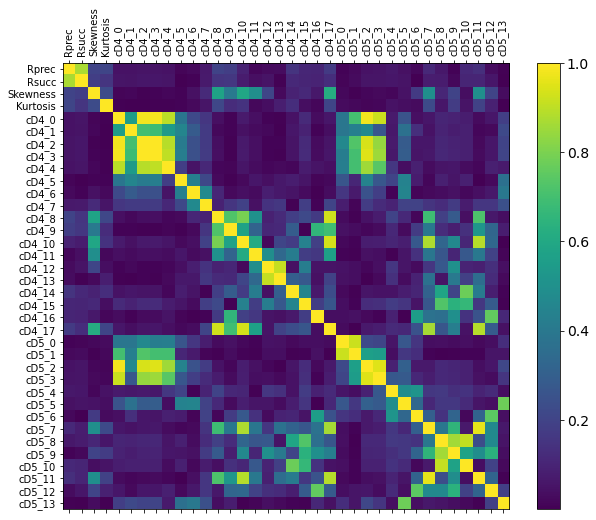

In [ ]:
cor_matrix = train_features.corr().abs()
plot_correlationMatrix(cor_matrix, feature_list)

In [ ]:
correlated_features = set()
correlation_matrix = train_features.corr()
median_corr = (correlation_matrix.abs()).median(axis=0)

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            if median_corr[i] < median_corr[j]:
                colname = correlation_matrix.columns[i]
            else:
                colname = correlation_matrix.columns[j]
            correlated_features.add(colname)           
print('Deleted features: ' + str(correlated_features))

Deleted features: {'cD4_0', 'cD4_10', 'cD4_4', 'cD4_12', 'cD5_10', 'cD4_8', 'cD5_2', 'cD4_2', 'cD5_11', 'cD5_1', 'cD4_3'}


In [ ]:
train_features.drop(labels=correlated_features, axis=1, inplace=True)

,Rprec,Rsucc,Skewness,Kurtosis,cD4_1,cD4_5,cD4_6,cD4_7,cD4_9,cD4_11,cD4_13,cD4_14,cD4_15,cD4_16,cD4_17,cD5_0,cD5_3,cD5_4,cD5_5,cD5_6,cD5_7,cD5_8,cD5_9,cD5_12,cD5_13
0,71,82,-1.886055,7.299344,0.061293,-0.739322,1.250308,0.514264,11.451065,2.854179,0.086433,0.433355,-0.431889,-5.807331,-9.176737,-0.062094,0.056930,-0.138400,-3.361488,-1.055155,5.956925,1.086574,-0.494353,3.877706,1.607069
1,82,79,-1.740336,5.877049,0.123797,-0.898810,1.245677,0.512359,11.836971,3.134500,0.187526,0.054726,-0.593886,-6.764620,-7.710402,0.211549,-0.416803,0.158421,-3.468398,-2.003671,4.367997,1.847240,-0.785639,5.119804,1.700222
2,79,48,-1.670844,3.118496,0.734192,-3.991323,2.702098,0.168613,11.173245,7.222213,-1.994089,-5.948672,0.747406,-6.051976,-8.698168,0.540908,-1.375245,-0.915813,-6.308843,0.070626,4.226973,-5.667262,0.014837,4.553798,2.168072
3,48,87,-1.811867,4.140602,0.015773,4.868568,11.113936,-4.660040,9.794215,3.270352,0.255063,-0.011006,0.126933,-6.101252,-8.485744,0.042063,-0.196105,0.969288,0.507314,-10.713019,8.341215,0.006623,-0.361768,8.148976,2.807639
4,87,52,-1.633142,5.385339,-0.047583,-0.426957,0.296631,0.849264,11.428106,3.333523,3.780928,-1.027917,-0.750592,-6.428806,-8.277499,0.015221,0.204304,1.540286,0.191533,-3.569325,5.315534,-5.816075,-0.327998,4.997815,0.088321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55649,286,280,-0.746377,2.586033,0.003430,-0.054093,0.066185,0.031116,-2.876779,1.398061,0.080870,-0.654852,0.790615,4.536430,-1.502530,-0.002232,0.013500,0.140236,0.096935,1.246035,3.423381,-2.345982,0.582383,-1.907616,0.481301
55650,280,272,-1.627396,5.646762,-0.001008,-0.160851,0.203715,-0.193574,-2.540920,1.386728,0.020214,-0.643018,0.557793,4.328504,-0.940868,-0.000528,0.025931,0.238635,0.375370,1.059838,3.717739,-2.404792,0.692703,-1.945819,0.282716
55651,272,286,-1.122363,4.204912,0.003646,-0.071306,-0.009043,-0.178970,-2.548036,1.577361,0.106495,-0.792869,0.468230,4.433000,-1.179178,0.004079,-0.019213,0.047807,-0.026052,1.539455,3.558941,-2.479435,0.616383,-2.029852,0.385929
55652,286,270,-1.601608,5.455945,0.010085,-0.292012,-0.073865,-0.297869,-2.569291,1.352829,0.104911,-0.765367,0.642840,4.272135,-0.971426,-0.009065,-0.008467,0.205088,0.000064,1.380699,3.416470,-2.718267,0.669446,-2.268417,0.695174


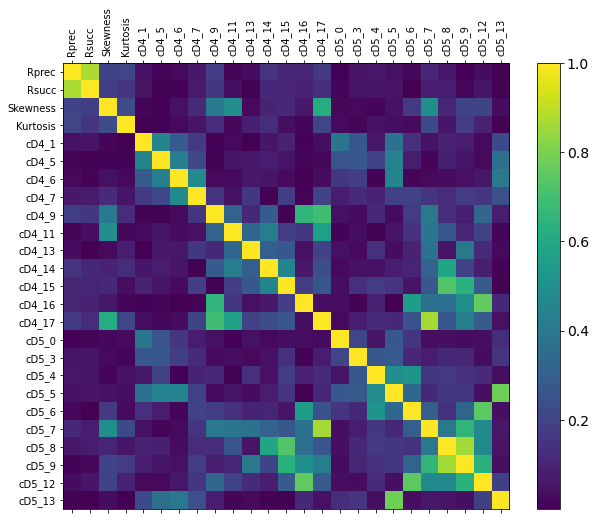

In [ ]:
cor_matrix = train_features.corr().abs()
feature_list = list(train_features.columns)
f2 = plot_correlationMatrix(cor_matrix, feature_list)

val_features = val_features[feature_list]
display(val_features)

# Shape adjusting

* Remove the heartbeats associated with the outliers in the wide features.
* Adjust the dataset shape to match the keras input

In [ ]:
trainDOWN = np.asarray(trainDOWN)
valDOWN = np.asarray(valDOWN)

In [ ]:
LEAD1 = trainDOWN[0]
LEAD2 = trainDOWN[1]
lead1_val = valDOWN[0]
lead2_val = valDOWN[1]

In [ ]:
x = np.stack((LEAD1, LEAD2), axis = 2)
x_val = np.stack((lead1_val, lead2_val), axis = 2)

In [ ]:
x_filtered = x[filtered_down.index]

In [ ]:
x_filtered.shape

(183501, 130, 2)

In [ ]:
x_val_filtered = x_val[filtered_val_down.index]

In [ ]:
x_val_filtered.shape

(55941, 130, 2)

In [ ]:
len(features_val)

55989

In [ ]:
y_val = pd.Series(y_val)

In [ ]:
y_val_filtered = y_val[filtered_val_down.index]

In [ ]:
y_train = pd.Series(y_train)

In [ ]:
y_train_filtered = y_train[filtered_down.index]

In [ ]:
y_train_filtered.shape

(183501,)

## Save filtered heartbeat

In [ ]:
#import pickle 
#with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/dataset_train_down_264_filtered.pickle","wb") as f:
#    pickle.dump(x_filtered,f)
#with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/y_train_down_264_filtered.pickle","wb") as f:
#    pickle.dump(y_train_filtered,f)
     

# Import Wide Features and Signals for the Ensemble

## Import Downsampled Signals

### Downsampled training set

In [ ]:
with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/NEW FILTERED V2/dataset_train_down_filtered.pickle","rb") as f:
  trainDOWN=pickle.load(f)
with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/NEW FILTERED V2/y_train_down_filtered.pickle","rb") as f:
  y_train=pickle.load(f)

### Downsampled validation set

In [ ]:
with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/NEW FILTERED V2/dataset_val_down_filtered.pickle","rb") as f:
  valDOWN=pickle.load(f)
with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/NEW FILTERED V2/y_val_down_filtered.pickle","rb") as f:
  y_val=pickle.load(f)

## Remove N element for S-V analysis

trainDOWN_sv

In [ ]:
trainDOWN_sv = []
for index, label in enumerate(y_train):
  if (label == 'S' or label == 'V'):
    trainDOWN_sv.append(trainDOWN[index])

valDOWN_sv

In [ ]:
valDOWN_sv = []
for index, label in enumerate(y_val):
  if (label == 'S' or label == 'V'):
    valDOWN_sv.append(valDOWN[index])

## Import Dataset With Wide Features

## All Dataset

In [ ]:
## TRINING
df_train= pd.read_csv('/content/drive/MyDrive/A.I/FinalProject/Dataset/NEW FILTERED V2/filtered_new.csv')
# Remove the first column with the index
df_train.drop(columns=['Unnamed: 0'], inplace=True)
## VALIDATION
df_val= pd.read_csv('/content/drive/MyDrive/A.I/FinalProject/Dataset/NEW FILTERED V2/val_filtered_new.csv')
# Remove the first column with the index
df_val.drop(columns=['Unnamed: 0'], inplace=True)

### Dataset transformation for keras

In [ ]:
X_train_df = df_train.iloc[:,0:-1]
y_train_df = df_train.iloc[:,-1]

In [ ]:
X_val_df = df_val.iloc[:,0:-1]
y_val_df = df_val.iloc[:,-1]

In [ ]:
# Conversion into keras tensor (train and val)
X_train_df_keras = tf.convert_to_tensor(X_train_df)
X_val_df_keras = tf.convert_to_tensor(X_val_df)

### Normalization layer

In [ ]:
# Generation of normalizer layer fitted over train
normalizer = tf.keras.layers.Normalization(name="NormalizationLayer",axis=-1)
normalizer.adapt(X_train_df_keras)

### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_df)

scaled_data_t = scaler.transform(X_train_df.astype(float))
scaled_X_train_df = pd.DataFrame(scaled_data_t.astype(float))
scaled_X_train_df.columns = X_train_df.columns

scaled_data_v = scaler.transform(X_val_df.astype(float))
scaled_X_val_df = pd.DataFrame(scaled_data_v.astype(float))
scaled_X_val_df.columns = X_val_df.columns

## Dataset S-V

In [ ]:
df_sv_train = df_train.drop(df_train[df_train.Target == 'N'].index)

In [ ]:
df_sv_val = df_val.drop(df_val[df_val.Target == 'N'].index)

### Dataset transformation for keras

In [ ]:
X_sv_train_df = df_sv_train.iloc[:,0:-1]
y_sv_train_df = df_sv_train.iloc[:,-1]

In [ ]:
X_sv_val_df = df_sv_val.iloc[:,0:-1]
y_sv_val_df = df_sv_val.iloc[:,-1]

In [ ]:
# Conversion into keras tensor (train and val)
X_sv_train_df_keras = tf.convert_to_tensor(X_sv_train_df)
X_sv_val_df_keras = tf.convert_to_tensor(X_sv_val_df)

### In this case we need also a new y

In [ ]:
y_sv_train_df_keras = y_sv_train_df.tolist()
y_sv_val_df_keras = y_sv_val_df.tolist()

### Scaling

In [ ]:
scaled_data_t = scaler.transform(X_sv_train_df.astype(float))
scaled_X_sv_train_df = pd.DataFrame(scaled_data_t.astype(float))
scaled_X_sv_train_df.columns = X_sv_train_df.columns

scaled_data_v = scaler.transform(X_sv_val_df.astype(float))
scaled_X_sv_val_df = pd.DataFrame(scaled_data_v.astype(float))
scaled_X_sv_val_df.columns = X_sv_val_df.columns

## Dataset N-M


In [ ]:
df_mn_train = deepcopy(df_train)
df_mn_train["Target"].replace({"S": "M", "V": "M"}, inplace=True)

In [ ]:
df_mn_val = deepcopy(df_val)
df_mn_val["Target"].replace({"S": "M", "V": "M"}, inplace=True)

### Dataset transformation for keras

In [ ]:
y_mn_train_df = df_mn_train.iloc[:,-1]
y_mn_val_df = df_mn_val.iloc[:,-1]

## One Hot Encoding

### 1) One Hot Encoding For N-S-V

#### One Hot Train for CNN

In [ ]:
#one hot train
num_classes = 3
one_hot_labels = np.zeros((len(y_train), 3), dtype=np.bool)

for i, single_label in enumerate (y_train):
  for j, x in enumerate(['N','S','V']):
    if (x in single_label):
      one_hot_labels[i][j] = 1
one_hot_labels_nsv = one_hot_labels * 1.

In [ ]:
trainDOWN=np.asarray(trainDOWN)

#### One Hot Val for CNN

In [ ]:
#one hot val
num_classes = 3
one_hot_labelsV = np.zeros((len(y_val), 3), dtype=np.bool)

for i, single_label in enumerate (y_val):
  for j, x in enumerate(['N','S','V']):
    if (x in single_label):
      one_hot_labelsV[i][j] = 1
one_hot_labelsV_nsv = one_hot_labelsV * 1.

In [ ]:
valDOWN=np.asarray(valDOWN)

### 1b) One Hot Encoding For M-N

#### One Hot Train for CNN/FNN

In [ ]:
#one hot train
num_classes = 2
one_hot_labels = np.zeros((len(y_mn_train_df), num_classes), dtype=np.bool)

for i, single_label in enumerate (y_mn_train_df):
  for j, x in enumerate(['N','M']):
    if (x in single_label):
      one_hot_labels[i][j] = 1
one_hot_labels = one_hot_labels * 1.

In [ ]:
one_hot_labels_nm = deepcopy(one_hot_labels)
one_hot_labels_nm

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

#### One Hot Val for CNN

In [ ]:
#one hot val
num_classes = 2
one_hot_labelsV = np.zeros((len(y_mn_val_df), num_classes), dtype=np.bool)

for i, single_label in enumerate (y_mn_val_df):
  for j, x in enumerate(['N','M']):
    if (x in single_label):
      one_hot_labelsV[i][j] = 1
one_hot_labelsV = one_hot_labelsV * 1.

In [ ]:
one_hot_labelsV_nm = deepcopy(one_hot_labelsV)
one_hot_labelsV_nm

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

### 1c) One Hot Encoding For S-V

#### One Hot Train for CNN/FNN

In [ ]:
#one hot train
num_classes = 2
one_hot_labels = np.zeros((len(y_sv_train_df_keras), num_classes), dtype=np.bool)

for i, single_label in enumerate (y_sv_train_df_keras):
  for j, x in enumerate(['S','V']):
    if (x in single_label):
      one_hot_labels[i][j] = 1
one_hot_labels = one_hot_labels * 1.

In [ ]:
one_hot_labels_sv = deepcopy(one_hot_labels)
one_hot_labels_sv

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

#### One Hot Val for CNN

In [ ]:
#one hot val
num_classes = 2
one_hot_labelsV = np.zeros((len(y_sv_val_df_keras), num_classes), dtype=np.bool)

for i, single_label in enumerate (y_sv_val_df_keras):
  for j, x in enumerate(['S','V']):
    if (x in single_label):
      one_hot_labelsV[i][j] = 1
one_hot_labelsV = one_hot_labelsV * 1.

In [ ]:
one_hot_labelsV_sv = deepcopy(one_hot_labelsV)
one_hot_labelsV_sv

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

# ✔️ Ensemble

## `Model Hybrid`

### Metrics

In [ ]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    #f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [ ]:
def ht(y_true, y_pred):
  #pred = y_pred.numpy()
  #pred = np.round(pred)
  gamma =  0.00000001
  #y_true = np.argmax(y_true.numpy(), axis=1)
  #y_pred = np.argmax(y_pred.numpy(), axis=1)

  matrix = confusion_matrix(y_true, y_pred)
  #print("\n\nComplete Matrix")
  #print(matrix)
  #pred_A = pred[:,0]
  #pred_B = pred[:,1]
  #pred_C = pred[:,2]

  #n_A = np.count_nonzero(pred_N, axis=0)
  #n_B = np.count_nonzero(pred_S, axis=0)
  #n_C = np.count_nonzero(pred_V, axis=0)

  if(matrix.shape[0]==2):
    if(matrix[0,0]==0 and matrix[0,1]==0):
      #print("only second row")
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1])
      return(b)

    elif(matrix[1,1]==0 and matrix[1,0]==0):
      #print("only first row")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1])
      return(a)

    else:
      #print("both")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1])
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1])
      return(2/((1/(a+gamma))+(1/(b+gamma))))

  elif(matrix.shape[0]==3):
    first_row_0 = (matrix[0,0]==0 and matrix[0,1]==0  and matrix[0,2]==0)
    second_row_0 = (matrix[1,0]==0 and matrix[1,1]==0  and matrix[1,2]==0)
    third_row_0 = (matrix[2,0]==0 and matrix[2,1]==0  and matrix[2,2]==0)

    if(first_row_0 and second_row_0):
      #print("only third row")
      c = matrix[2,2]/(matrix[2,0]+matrix[2,1]+matrix[2,2])
      return(c)
    elif(first_row_0 and third_row_0):
      #print("only second row")
      c = matrix[1,1]/(matrix[1,0]+matrix[1,1]+matrix[1,2])
      return(c)
    elif(second_row_0 and third_row_0):
      #print("only first row")
      c = matrix[0,0]/(matrix[0,0]+matrix[0,1]+matrix[0,2])
      return(c)

    elif(first_row_0):
      #print("only second and third row")
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1]+matrix[1,2])
      c = matrix[2,2]/(matrix[2,0]+matrix[2,1]+matrix[2,2])
      return(2/((1/(b+gamma))+(1/(c+gamma))))  
    elif(second_row_0):
      #print("only first and third row")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1]+matrix[0,2])
      c = matrix[2,2]/(matrix[2,0]+matrix[2,1]+matrix[2,2])
      return(2/((1/(a+gamma))+(1/(c+gamma))))
    elif(third_row_0):
      #print("only first and second row")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1]+matrix[0,2])
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1]+matrix[1,2])
      return(2/((1/(a+gamma))+(1/(b+gamma))))

    else:
      #print("all")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1]+matrix[0,2])
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1]+matrix[1,2])
      c = matrix[2,2]/(matrix[2,0]+matrix[2,1]+matrix[2,2])
      return(3/((1/(a+gamma))+(1/(b+gamma))+(1/(c+gamma))))

  else:
    return(matrix[0,0])





def trace(y_true, y_pred):
  #pred = y_pred.numpy()
  #pred = np.round(pred)

  y_true = np.argmax(y_true.numpy(), axis=1)
  y_pred = np.argmax(y_pred.numpy(), axis=1)

  matrix = confusion_matrix(y_true, y_pred)
  #print("\n\nComplete Matrix")
  #print(matrix)
  #pred_N = pred[:,0]
  #pred_S = pred[:,1]
  #pred_V = pred[:,2]

  #n_N = np.count_nonzero(pred_N, axis=0)
  #n_S = np.count_nonzero(pred_S, axis=0)
  #n_V = np.count_nonzero(pred_V, axis=0)

  if(matrix.shape[0]==2):
    if(matrix[0,0]==0 and matrix[0,1]==0):
      #print("only second row")
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1])
      return(b)

    elif(matrix[1,1]==0 and matrix[1,0]==0):
      #print("only first row")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1])
      return(a)

    else:
      #print("both")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1])
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1])
      return((a+b)/2)

  elif(matrix.shape[0]==3):
    first_row_0 = (matrix[0,0]==0 and matrix[0,1]==0  and matrix[0,2]==0)
    second_row_0 = (matrix[1,0]==0 and matrix[1,1]==0  and matrix[1,2]==0)
    third_row_0 = (matrix[2,0]==0 and matrix[2,1]==0  and matrix[2,2]==0)

    if(first_row_0 and second_row_0):
      #print("only third row")
      c = matrix[2,2]/(matrix[2,0]+matrix[2,1]+matrix[2,2])
      return(c)
    elif(first_row_0 and third_row_0):
      #print("only second row")
      c = matrix[1,1]/(matrix[1,0]+matrix[1,1]+matrix[1,2])
      return(c)
    elif(second_row_0 and third_row_0):
      #print("only first row")
      c = matrix[0,0]/(matrix[0,0]+matrix[0,1]+matrix[0,2])
      return(c)

    elif(first_row_0):
      #print("only second and third row")
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1]+matrix[1,2])
      c = matrix[2,2]/(matrix[2,0]+matrix[2,1]+matrix[2,2])
      return((b+c)/2)  
    elif(second_row_0):
      #print("only first and third row")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1]+matrix[0,2])
      c = matrix[2,2]/(matrix[2,0]+matrix[2,1]+matrix[2,2])
      return((a+c)/2) 
    elif(third_row_0):
      #print("only first and second row")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1]+matrix[0,2])
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1]+matrix[1,2])
      return((a+b)/2) 

    else:
      #print("all")
      a = matrix[0,0]/(matrix[0,0]+matrix[0,1]+matrix[0,2])
      b = matrix[1,1]/(matrix[1,0]+matrix[1,1]+matrix[1,2])
      c = matrix[2,2]/(matrix[2,0]+matrix[2,1]+matrix[2,2])
      return((a+b+c)/3)

  else:
    return(matrix[0,0])

In [ ]:
%pip install focal-loss

In [ ]:
from focal_loss import BinaryFocalLoss

Fixed Focal loss function able to work also with CategoricalCrossentropy (One Hot encoding)

In [ ]:
from keras import backend as K
import tensorflow as tf

# Compatible with tensorflow backend

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed

### Import models

In [ ]:
from tensorflow import keras

model_MN = keras.models.load_model('/content/drive/MyDrive/A.I/FinalProject/ModelsKarim/ModelsAutoSearch/HybridV5_FL_NM_trial_4_block_A_Jan10_01-12-06/ckpts/cp.ckpt',custom_objects={"f1":f1, "focal_loss_fixed":focal_loss})
model_SV = keras.models.load_model('/content/drive/MyDrive/A.I/FinalProject/ModelsKarim/ModelsAutoSearch/HybridModelV5_FL_SV_Jan10_10-49-28/ckpts/cp.ckpt',custom_objects={"f1":f1, "focal_loss_fixed":focal_loss})

### Prediction for model_MN

In [ ]:
input_val_cnn_nm = valDOWN
input_val_wide_nm = normalizer(X_val_df_keras)

In [ ]:
predictionMN = model_MN.predict([input_val_wide_nm,input_val_cnn_nm])
decoded_validation = np.argmax(one_hot_labelsV_nm, axis=1)
decoded_prediction = np.argmax(np.around(predictionMN), axis=1)

### Prediction for model_SV

In [ ]:
valDOWN_sv=np.asarray(valDOWN_sv)

In [ ]:
input_val_cnn_sv = valDOWN_sv
input_val_wide_sv = normalizer(X_sv_val_df_keras)

In [ ]:
predictionSV = model_SV.predict([input_val_wide_sv, input_val_cnn_sv])
decoded_validation = np.argmax(one_hot_labelsV_sv, axis=1)
decoded_prediction = np.argmax(np.around(predictionSV), axis=1)

### Prediction Healthy vs Pathological

In [ ]:
# Start with the prediction of the MN model
decoded_predictionMN = np.argmax(np.around(predictionMN), axis=1)

In [ ]:
# Extraction of the non N beats (M)
m_beats_list_wide = []
# Composition of the new predictor vector for SV
m_window_list_CNN = []
for i,beat in enumerate(decoded_predictionMN):
  if beat==1:
    m_window_list_CNN.append(valDOWN[i])

for i,beat in enumerate(decoded_predictionMN):
  if beat==1:
    m_beats_list_wide.append(np.asarray(X_val_df_keras[i]))


m_beats_list_wide = np.asarray(m_beats_list_wide)
m_window_list_CNN = np.asarray(m_window_list_CNN)

### Prediction PAC vs PVC

In [ ]:
input_val_cnn_ensemble = m_window_list_CNN
input_val_wide_ensemble = normalizer(m_beats_list_wide)

In [ ]:
# Make the predictions for the non N beats 
new_predictionSV = model_SV.predict([input_val_wide_ensemble,input_val_cnn_ensemble])
new_decoded_predictionSV = np.argmax(np.around(new_predictionSV), axis=1)

### Prediction Complete

In [ ]:
# Substitute the M value with the new prediction
new_pred_list = []
# Composition of the new predictor vector for SV
count=0
for i,beat in enumerate(decoded_predictionMN):
  if beat==0:
    new_pred_list.append('N')
  else:
    if new_decoded_predictionSV[count] == 0:
      new_pred_list.append('S')
    else:
      new_pred_list.append('V')
    count=count+1

#### One hot conversion

In [ ]:
#one hot val
num_classes = 3
one_hot_labels = np.zeros((len(new_pred_list), 3), dtype=np.bool)

for i, single_label in enumerate (new_pred_list):
  for j, x in enumerate(['N','S','V']):
    if (x in single_label):
      one_hot_labels[i][j] = 1
one_hot_labels_pred = one_hot_labels * 1.

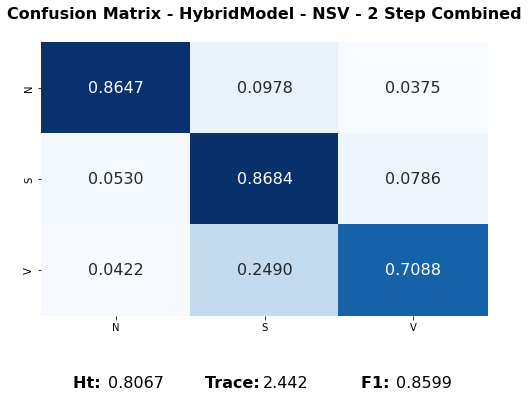

In [ ]:
# Metrics
matrix = confusion_matrix(y_val, new_pred_list)
norm_matrix = matrix/matrix.sum(axis=1)[:, np.newaxis]
trace_plot = norm_matrix.trace().round(4)
ht_plot = ht(y_val, new_pred_list).round(4)
f1_plot = f1_score(one_hot_labelsV_nsv , one_hot_labels_pred, average="samples").round(4)

# Dataframe Conversion
norm_matrix = pd.DataFrame(norm_matrix, columns = ['N','S','V'], index = ['N', 'S', 'V'])

# Plot
plt.figure(figsize=(8, 10))
plt.title("Confusion Matrix - HybridModel - NSV - 2 Step Combined\n",fontsize=16, fontweight="bold")
sns.heatmap(norm_matrix, annot=True, fmt='0.4f', cmap="Blues", cbar=False, annot_kws={"fontsize":16})
plt.figtext(0.18, 0.4, "Ht: ", fontsize=16, fontweight="bold")
plt.figtext(0.24, 0.4, str(ht_plot), fontsize=16)
plt.figtext(0.41, 0.4, "\nTrace: ", fontsize=16, fontweight="bold")
plt.figtext(0.51, 0.4, str(trace_plot), fontsize=16)
plt.figtext(0.68, 0.4, "\nF1: ", fontsize=16, fontweight="bold")
plt.figtext(0.74, 0.4, str(f1_plot), fontsize=16)

plt.subplots_adjust(bottom=0.5)
plt.show()

## `Model Deep STFT` 

### Import 264 Window

In [ ]:
# Directorty for the models
exps_dir="/content/drive/MyDrive/A.I/FinalProject/modelSEBA/models"

In [ ]:
with open("/content/drive/MyDrive/A.I/FinalProject/Dataset/dataset_val_down_264_filtered.pickle","rb") as f:
    valUP=pickle.load(f)

### Import Models

In [ ]:
model1 = tfk.models.load_model(os.path.join(exps_dir, str('best_model/STFT_step1_t7_ovf')))
model2 = tfk.models.load_model(os.path.join(exps_dir, str('best_model/STFT_step2_t7_stab')))

### STFT Generation

In [ ]:
from scipy import signal

band=30
time=7
freq=128
sub_window=88
m1=6.943412950379595
m2=6.815962391462233

#replicate STFT preprocessin (notice the signal fed to it is already preprocessed in the common way to all the models in this script 
#(downsampling to 128 Hz, bandpass filtering, 0 mean, standard deeviation, windowing of heartbeats of 264 samples))

ZxxV = np.empty(shape=(len(valUP),band,time,2))
for i in range(len(valUP)):
    f1,t1,val1= signal.stft(valUP[i,:,0], freq , nperseg=sub_window)
    f2,t2,val2= signal.stft(valUP[i,:,1], freq , nperseg=sub_window)
    ZxxV[i,:,:,0]=np.abs(val1[0:band])
    ZxxV[i,:,:,1]=np.abs(val2[0:band])


for i in range(ZxxV.shape[0]):
    for j in range(time):
        for k in range (band):
            ZxxV[i,k,j,0]=(ZxxV[i,k,j,0])/(m1/2.)-1.
            ZxxV[i,k,j,1]=(ZxxV[i,k,j,1])/(m2/2.)-1.

### Prediction Healthy vs Pathological

In [ ]:
pred1 =  model1.predict(ZxxV)

#### Pathological Data

In [ ]:
ZxxVsv=[] #samples classified as D by the first step and therefore fed to the step 2 classifier
posD=[]
for i in range(pred1.shape[0]):
  if pred1[i][0]<pred1[i][1]: #probability to be N lower than to be D
    ZxxVsv.append(ZxxV[i])
    posD.append(i)
ZxxVsv=np.array(ZxxVsv)
ZxxVsv.shape

(11249, 30, 7, 2)

### Prediction Model PAC vs PVC

In [ ]:
pred2 = model2.predict(ZxxVsv)

### Prediction Complete

In [ ]:
prediction_seba=np.zeros((ZxxV.shape[0],3))
for i in range(ZxxV.shape[0]):
  if pred1[i][0]>pred1[i][1]:
    prediction_seba[i][0]=1
  else:
    for j,pos in enumerate(posD):
      if i==pos:
        if pred2[j][0]>pred2[j][1]: #probability of S greater than V
          prediction_seba[i][1]=1
        else:
          prediction_seba[i][2]=1

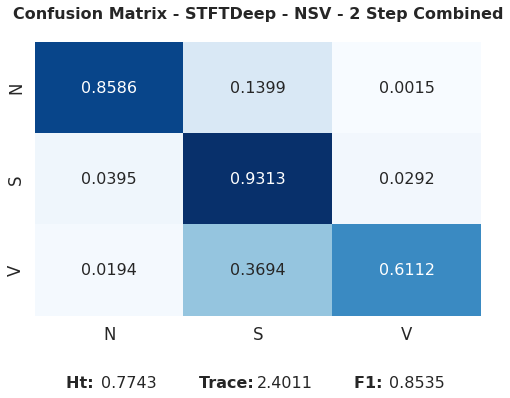

In [ ]:
# Metrics
matrix = confusion_matrix(np.argmax(one_hot_labelsV_nsv, axis=1), np.argmax(prediction_seba, axis=1))
norm_matrix = matrix/matrix.sum(axis=1)[:, np.newaxis]

trace_plot = norm_matrix.trace().round(4)
ht_plot = ht(np.argmax(one_hot_labelsV_nsv, axis=1), np.argmax(prediction_seba, axis=1)).round(4)
f1_plot = f1_score(one_hot_labelsV_nsv, prediction_seba , average="samples").round(4)

# Dataframe Conversion
norm_matrix = pd.DataFrame(norm_matrix, columns = ['N','S','V'], index = ['N', 'S', 'V'])

# Plot
plt.figure(figsize=(8, 10))
plt.title("Confusion Matrix - STFTDeep - NSV - 2 Step Combined\n",fontsize=16, fontweight="bold")
sns.heatmap(norm_matrix, annot=True, fmt='0.4f', cmap="Blues", cbar=False, annot_kws={"fontsize":16})
plt.figtext(0.18, 0.4, "Ht: ", fontsize=16, fontweight="bold")
plt.figtext(0.24, 0.4, str(ht_plot), fontsize=16)
plt.figtext(0.41, 0.4, "\nTrace: ", fontsize=16, fontweight="bold")
plt.figtext(0.51, 0.4, str(trace_plot), fontsize=16)
plt.figtext(0.68, 0.4, "\nF1: ", fontsize=16, fontweight="bold")
plt.figtext(0.74, 0.4, str(f1_plot), fontsize=16)

plt.subplots_adjust(bottom=0.5)
plt.show()

## `Model KNN` 

### Generate Dataset

In [ ]:
X_train_knn = deepcopy(scaled_X_train_df)
X_val_knn = deepcopy(scaled_X_val_df)

In [ ]:
X_train_knn[['Rprec', 'Rsucc', 'Kurtosis', 'Skewness']]=X_train_knn[['Rprec', 'Rsucc', 'Kurtosis', 'Skewness']]*14
X_val_knn[['Rprec', 'Rsucc', 'Kurtosis', 'Skewness']]=X_val_knn[['Rprec', 'Rsucc', 'Kurtosis', 'Skewness']]*14

### Load model and make predictions 

In [ ]:
# load the model from disk
knn_model = pickle.load(open("/content/drive/MyDrive/A.I/FinalProject/ModelsKarim/FinalModels/knn_nsv.sav", 'rb'))
knn_prediction = knn_model.predict(X_val_knn)

### Convert predictions in one hot encoding

In [ ]:
#one hot val
num_classes = 3
one_hot_labels = np.zeros((len(knn_prediction), 3), dtype=np.bool)

for i, single_label in enumerate (knn_prediction):
  for j, x in enumerate(['N','S','V']):
    if (x in single_label):
      one_hot_labels[i][j] = 1
one_hot_labels_knn = one_hot_labels * 1.

In [ ]:
# Metrics
matrix = confusion_matrix(y_val_df, knn_prediction, labels=["N", "S", "V"])
norm_matrix = matrix/matrix.sum(axis=1)[:, np.newaxis]

trace_plot = norm_matrix.trace().round(4)
ht_plot = ht(y_val_df,knn_prediction).round(4)
f1_plot = sklearn.metrics.f1_score(one_hot_labelsV_nsv, one_hot_labels_knn, average="samples").round(4)

# Dataframe Conversion
norm_matrix = pd.DataFrame(norm_matrix, columns = ['N','S','V'], index = ['N', 'S', 'V'])

# Plot
plt.figure(figsize=(8, 10))
plt.title("Confusion Matrix - NSV - KNN weighted - n:20",fontsize=16, fontweight="bold")
sns.heatmap(norm_matrix, annot=True, fmt='0.4f', cmap="Blues", cbar=False, annot_kws={"fontsize":16})
plt.figtext(0.18, 0.4, "Ht: ", fontsize=16, fontweight="bold")
plt.figtext(0.24, 0.4, str(ht_plot), fontsize=16)
plt.figtext(0.41, 0.4, "\nTrace: ", fontsize=16, fontweight="bold")
plt.figtext(0.51, 0.4, str(trace_plot), fontsize=16)
plt.figtext(0.68, 0.4, "\nF1: ", fontsize=16, fontweight="bold")
plt.figtext(0.74, 0.4, str(f1_plot), fontsize=16)

plt.subplots_adjust(bottom=0.5)
plt.show()

## Final Ensemble Prediction

In [ ]:
FTmatrix_train  = np.concatenate([np.expand_dims(prediction_seba, axis=2),np.expand_dims(one_hot_labels_pred, axis=2),np.expand_dims(one_hot_labels_knn, axis=2)], axis=2) 

### Define function to combine predictions (weighted)

In [ ]:
def prediction(matrix, a, b, c):
  lista = np.empty((matrix.shape[0],matrix.shape[1]))
  for i in range (matrix.shape[0]):
    N = a*matrix[i][0][0] + b*matrix[i][0][1] + c*matrix[i][0][2]
    S = a*matrix[i][1][0] + b*matrix[i][1][1] + c*matrix[i][1][2]
    V = a*matrix[i][2][0] + b*matrix[i][2][1] + c*matrix[i][2][2]

    lista[i][0]=N
    lista[i][1]=S
    lista[i][2]=V

  return lista

### Prediction

In [ ]:
ens_pred = prediction(FTmatrix_train, 0.03, 0.49, 0.48)

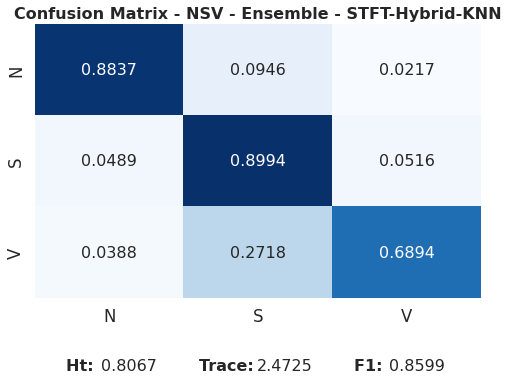

In [ ]:
# Metrics
matrix = confusion_matrix(np.argmax(one_hot_labelsV_nsv, axis=1), np.argmax(ens_pred, axis=1))
norm_matrix = matrix/matrix.sum(axis=1)[:, np.newaxis]

trace_plot = norm_matrix.trace().round(4)
ht_plot = ht(y_val, new_pred_list).round(4)
f1_plot = f1_score(one_hot_labelsV_nsv , one_hot_labels_pred, average="samples").round(4)

# Dataframe Conversion
norm_matrix = pd.DataFrame(norm_matrix, columns = ['N','S','V'], index = ['N', 'S', 'V'])

# Plot
plt.figure(figsize=(8, 10))
plt.title("Confusion Matrix - NSV - Ensemble - STFT-Hybrid-KNN",fontsize=16, fontweight="bold")
sns.heatmap(norm_matrix, annot=True, fmt='0.4f', cmap="Blues", cbar=False, annot_kws={"fontsize":16})
plt.figtext(0.18, 0.4, "Ht: ", fontsize=16, fontweight="bold")
plt.figtext(0.24, 0.4, str(ht_plot), fontsize=16)
plt.figtext(0.41, 0.4, "\nTrace: ", fontsize=16, fontweight="bold")
plt.figtext(0.51, 0.4, str(trace_plot), fontsize=16)
plt.figtext(0.68, 0.4, "\nF1: ", fontsize=16, fontweight="bold")
plt.figtext(0.74, 0.4, str(f1_plot), fontsize=16)

plt.subplots_adjust(bottom=0.5)
plt.show()